In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import scipy.io
import seaborn as sns
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('/content/drive/MyDrive/48kz/all_faults.csv')

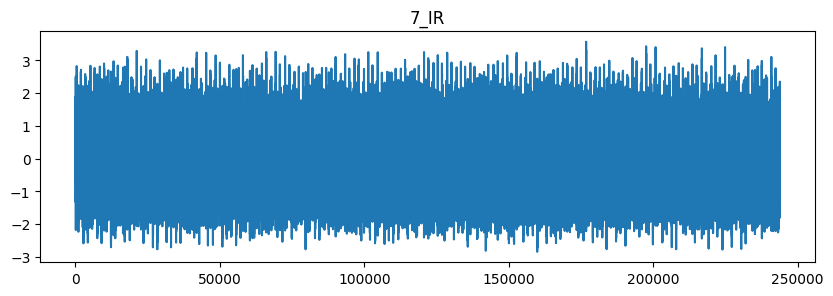

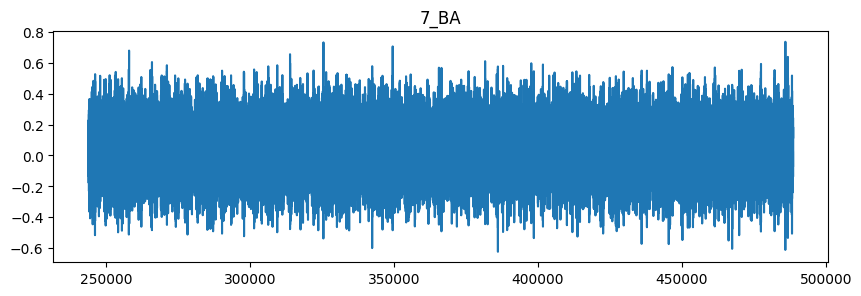

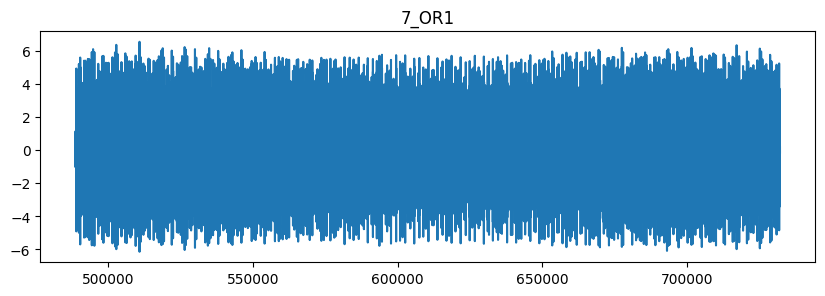

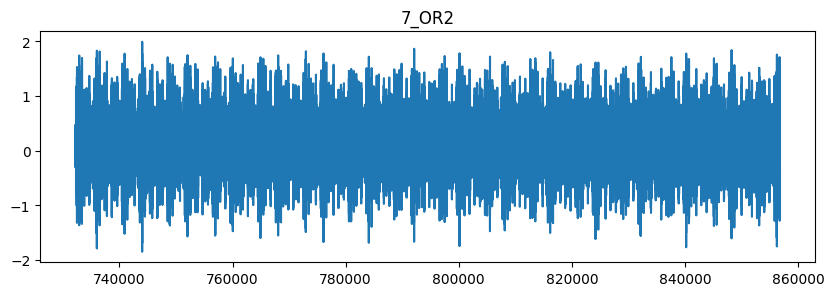

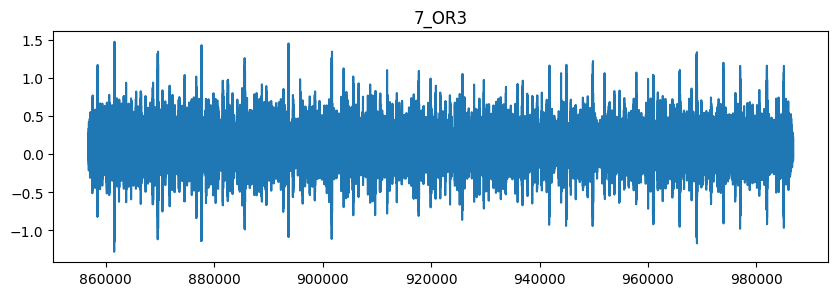

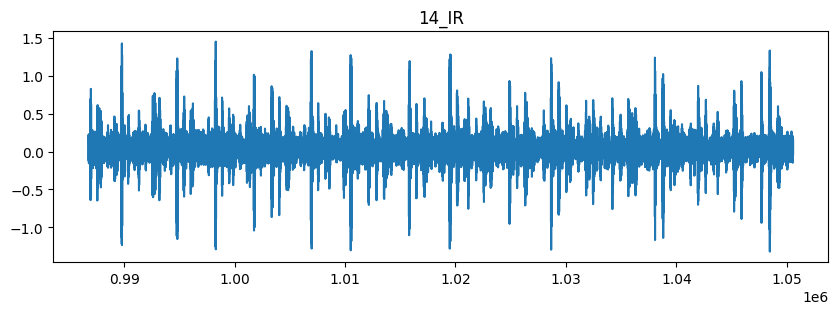

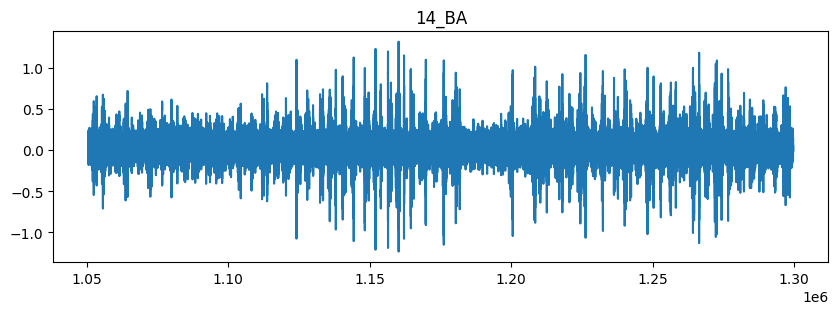

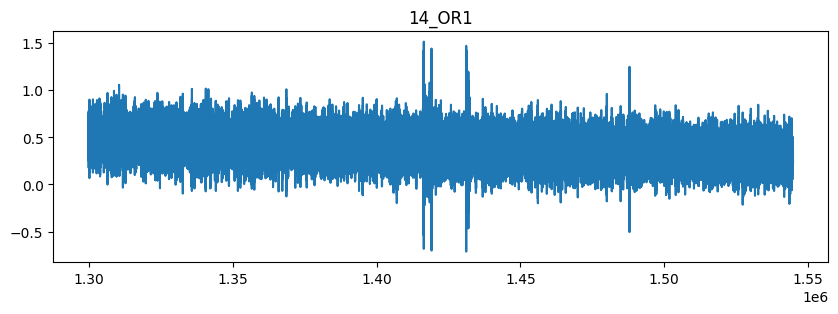

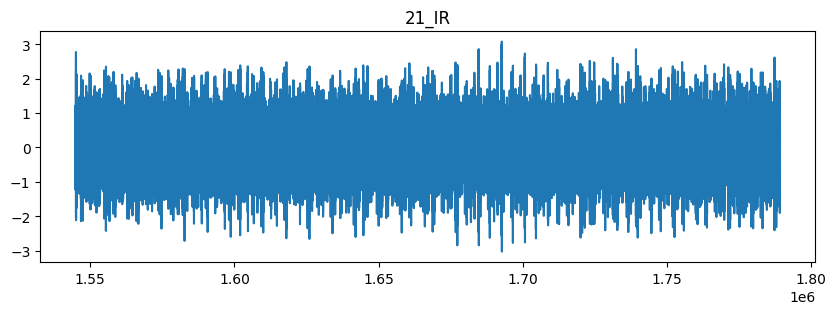

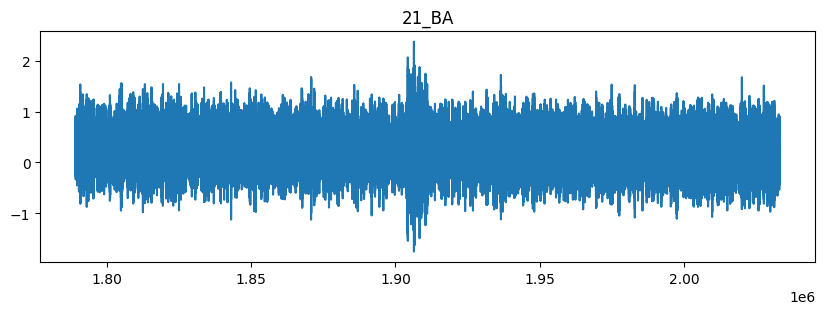

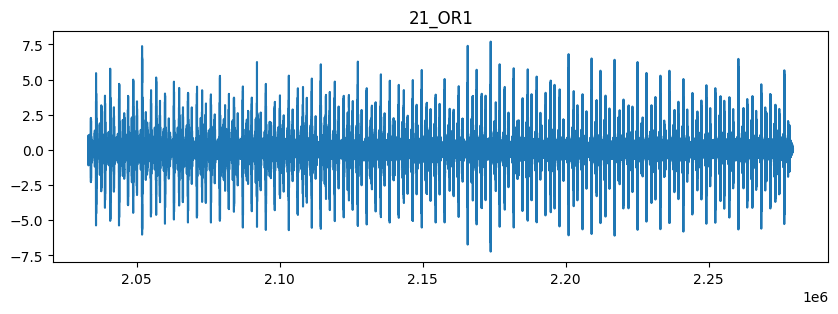

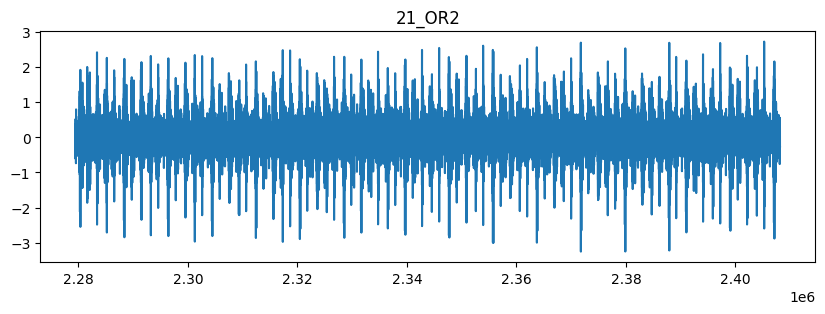

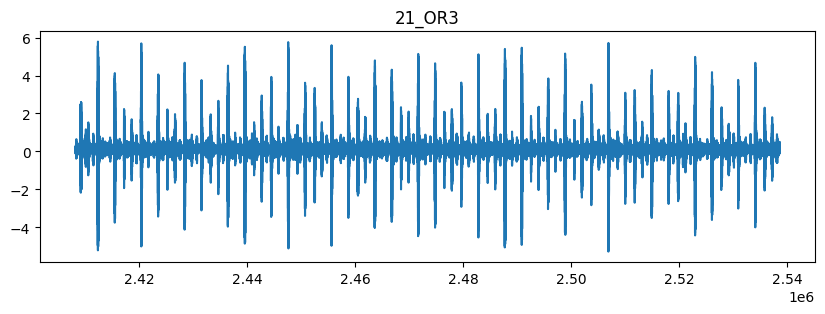

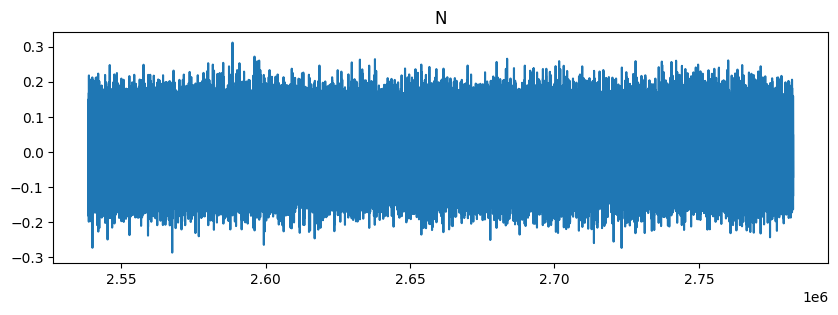

In [4]:

faults = df['fault'].unique()
for  f in faults:
    plt.figure(figsize=(10,3))
    plt.plot(df[df['fault']==f].iloc[:,0])
    plt.title(f)
    plt.show()

In [5]:
pip install tensorflow

In [6]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

win_len=784
stride=300

X=[]
Y=[]


for k in df['fault'].unique():

    df_temp_2 = df[df['fault']==k]

    for i in np.arange(0,len(df_temp_2)-(win_len),stride):
        temp = df_temp_2.iloc[i:i+win_len,:-1].values
        temp = temp.reshape((1,-1))
        X.append(temp)
        Y.append(df_temp_2.iloc[i+win_len,-1])

X=np.array(X)
X=X.reshape((X.shape[0],28,28,1))
#X = np.repeat(X, 3, axis=3) # To repeat into 3 chanel format


Y=np.array(Y)
encoder= LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)
OHE_Y = to_categorical(encoded_Y)

In [7]:
X.shape

(9246, 28, 28, 1)

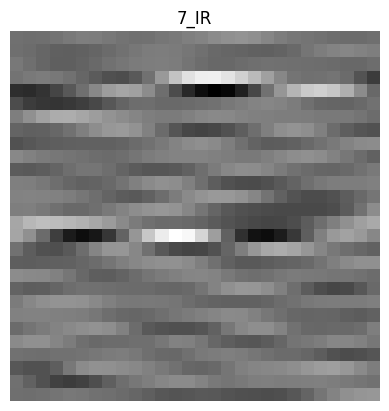

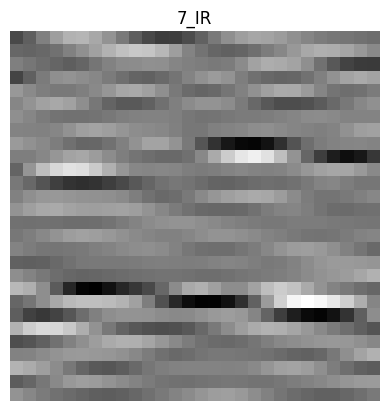

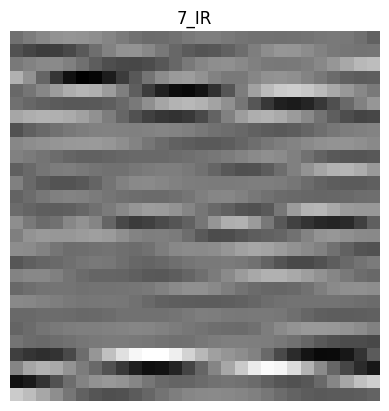

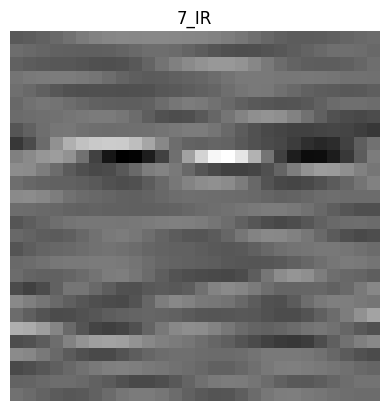

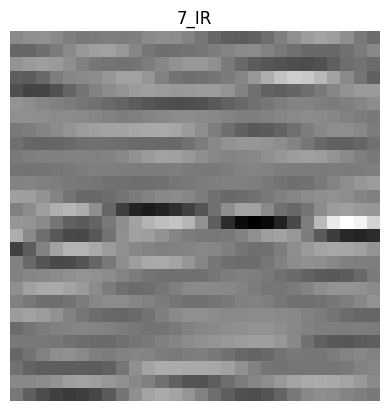

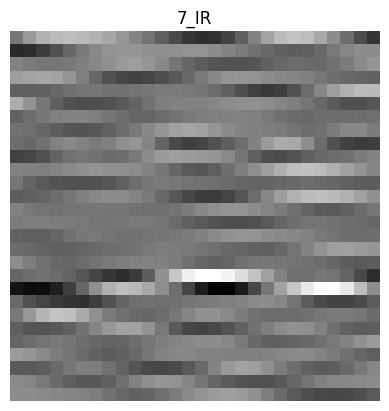

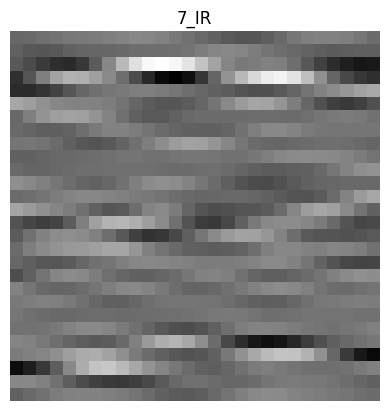

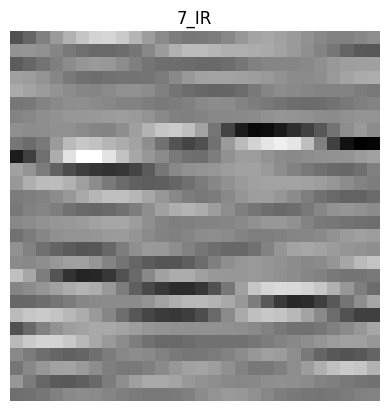

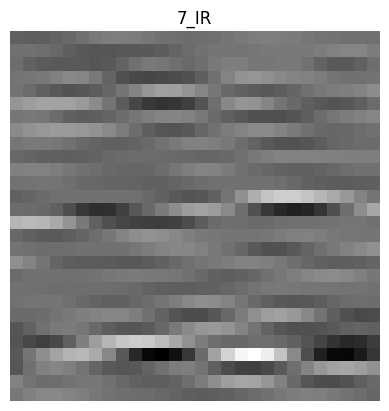

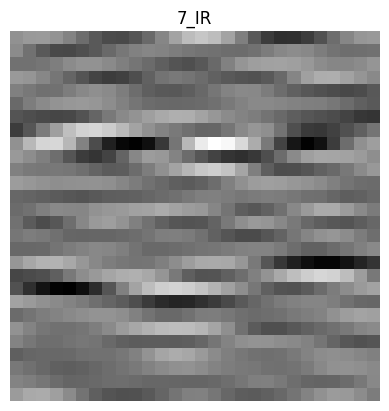

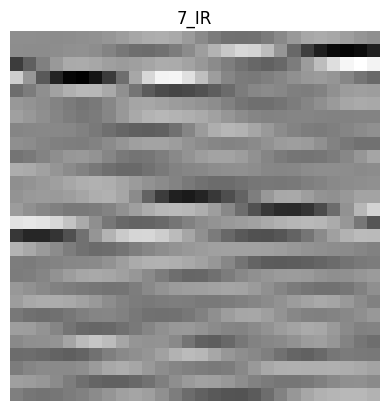

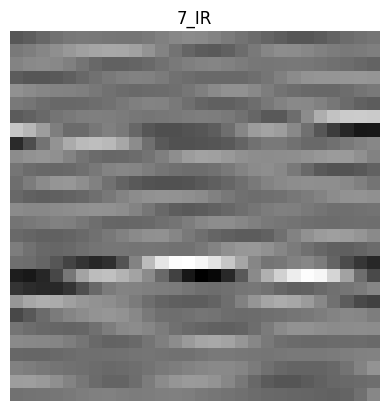

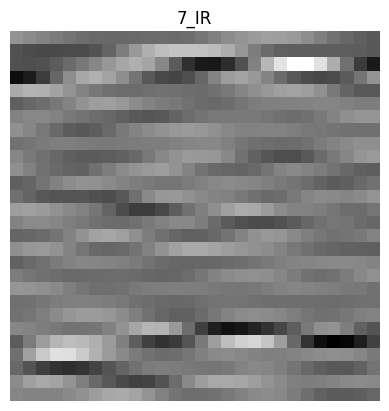

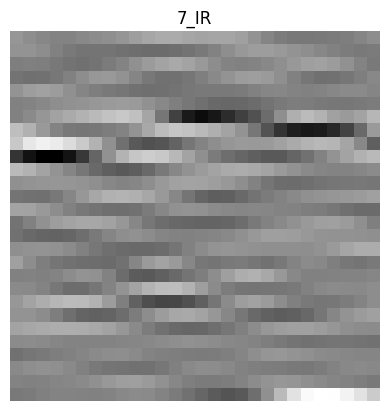

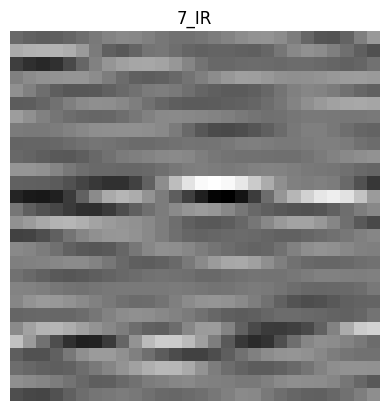

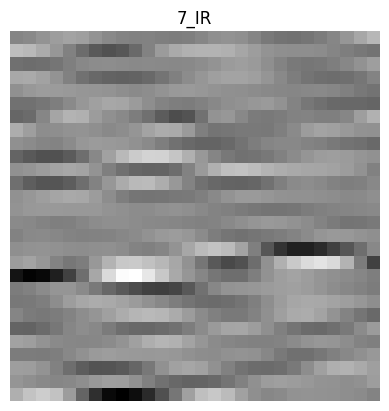

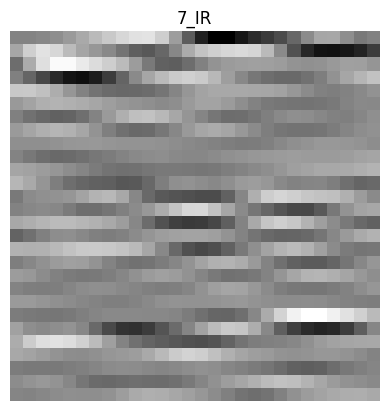

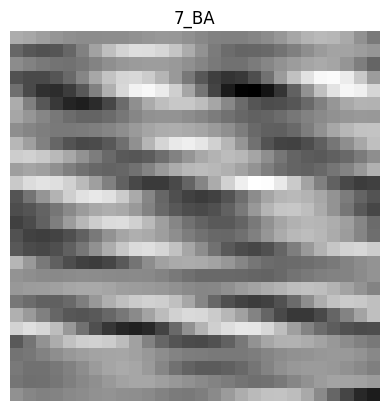

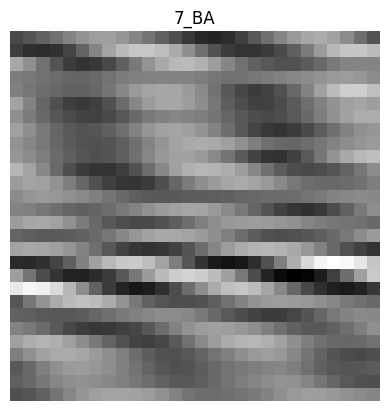

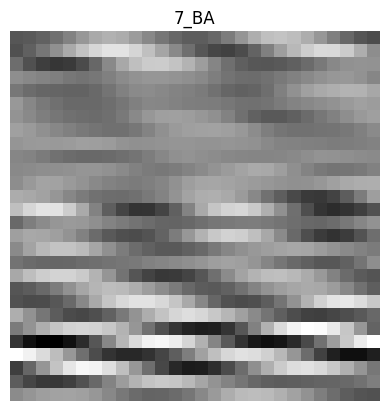

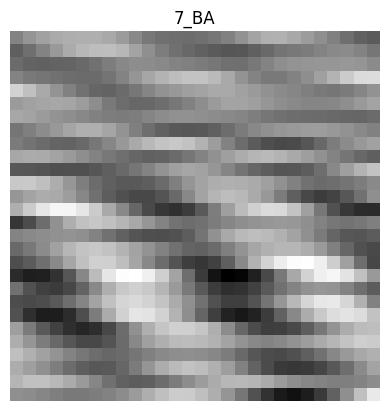

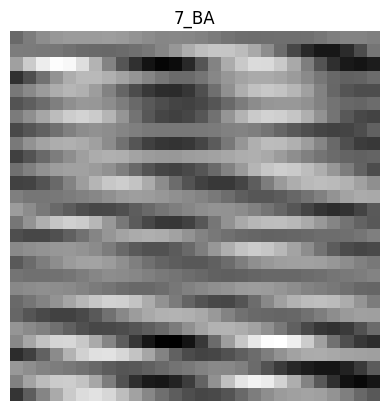

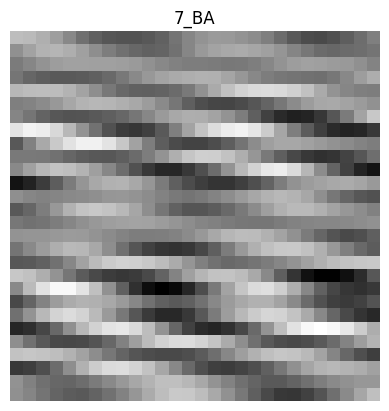

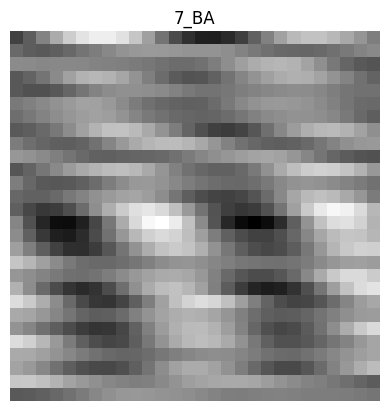

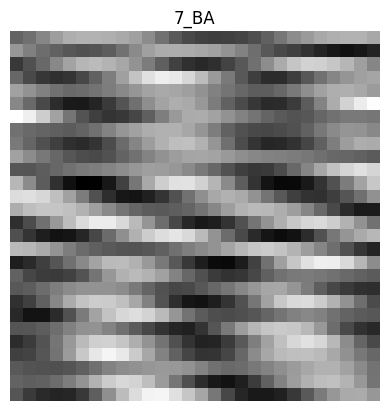

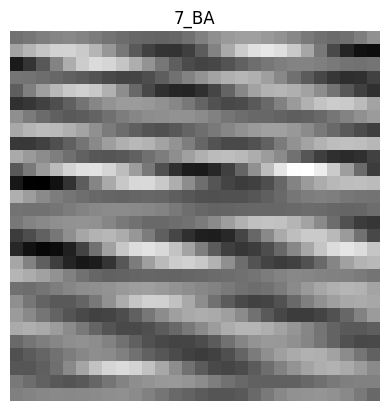

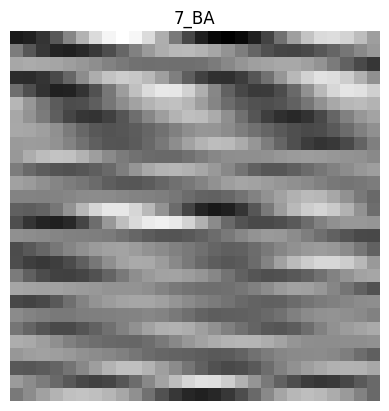

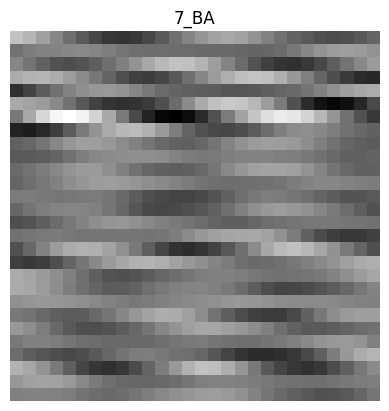

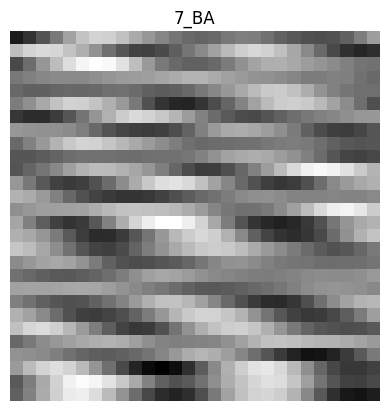

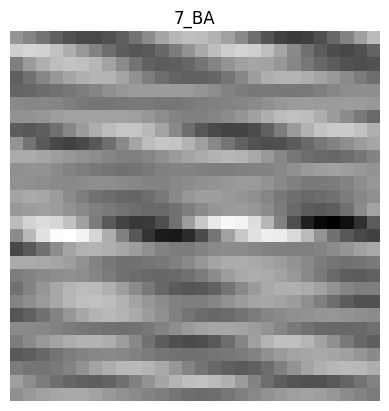

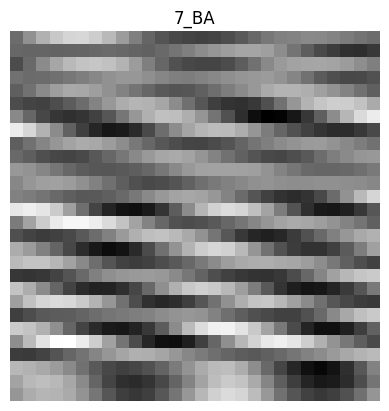

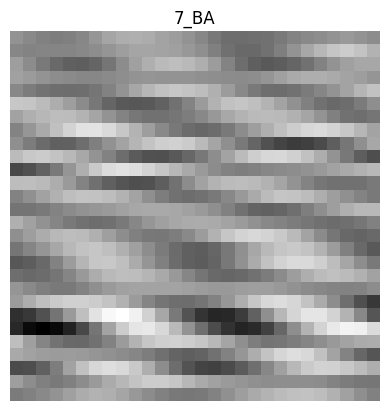

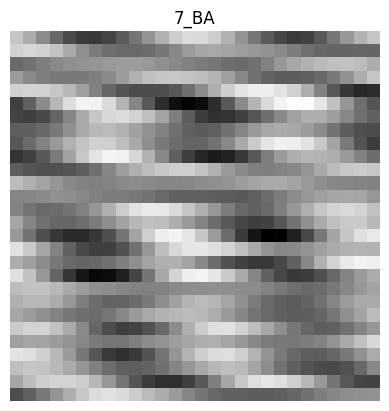

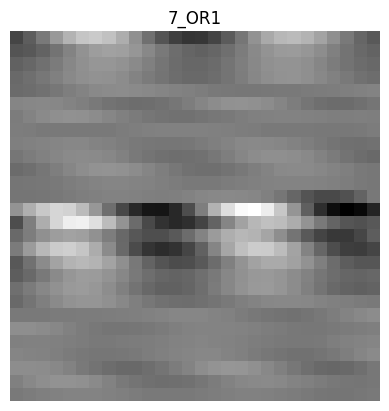

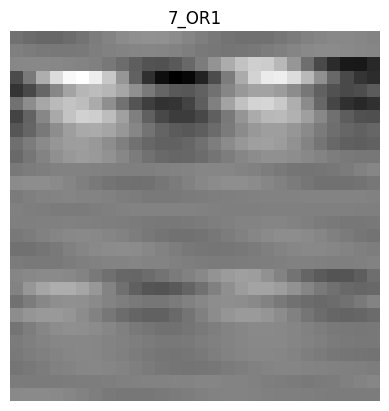

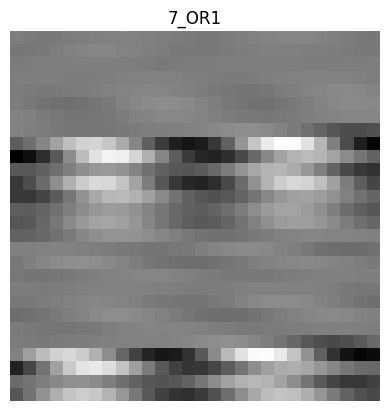

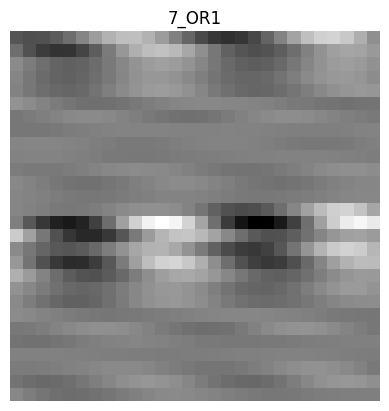

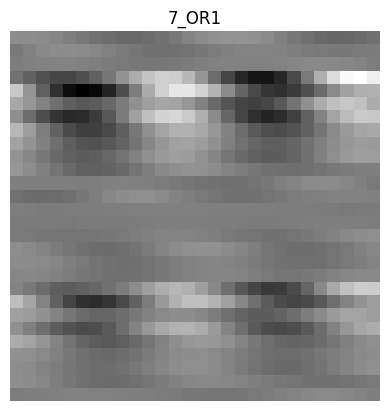

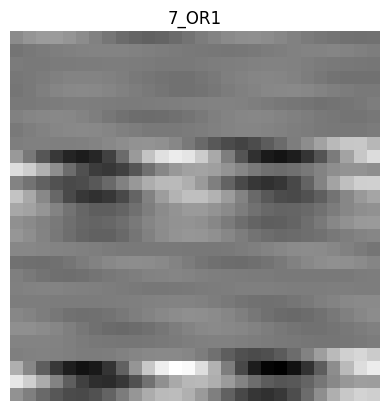

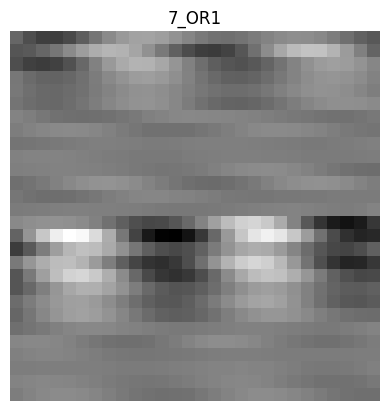

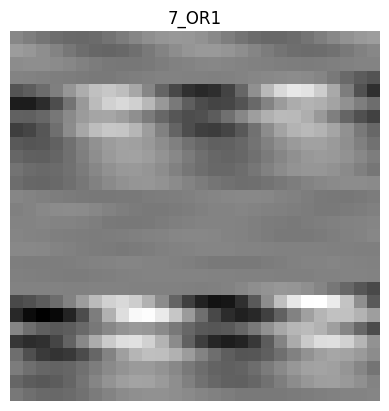

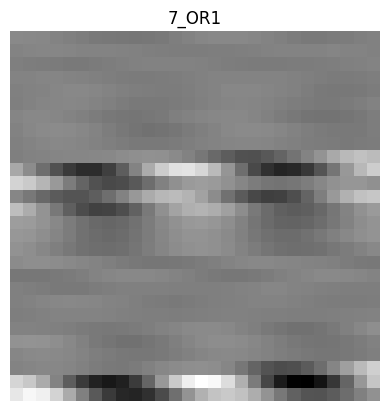

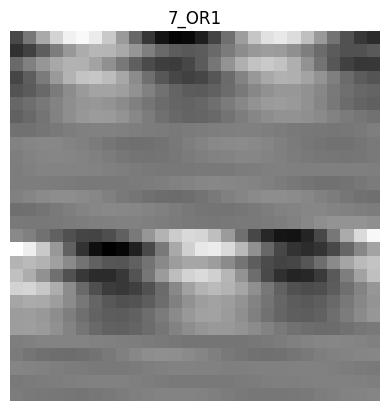

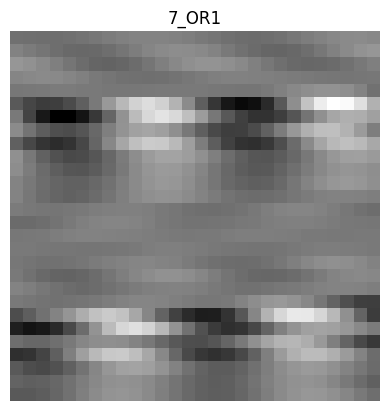

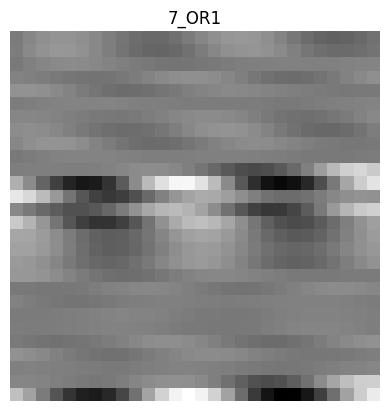

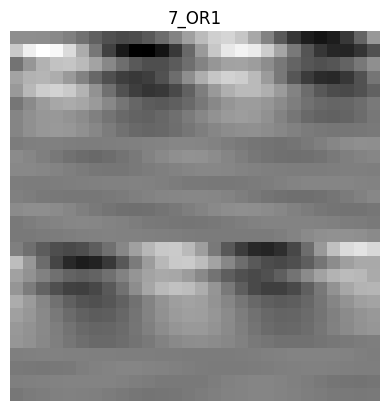

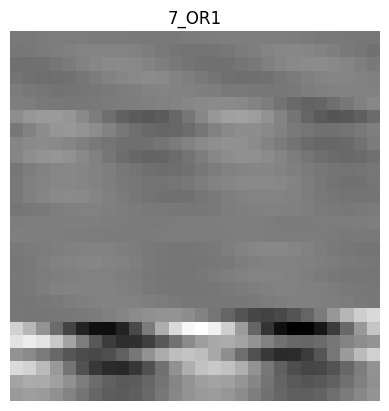

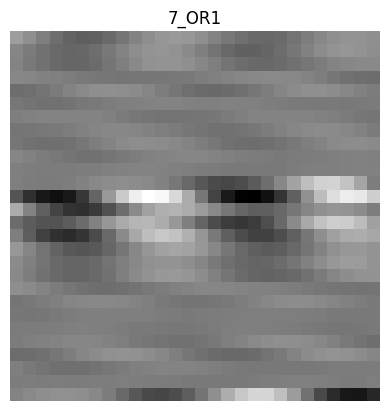

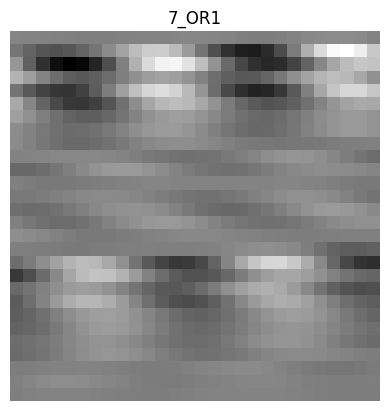

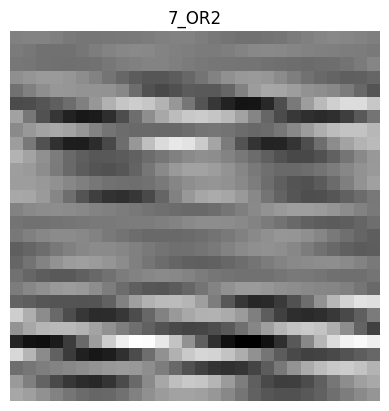

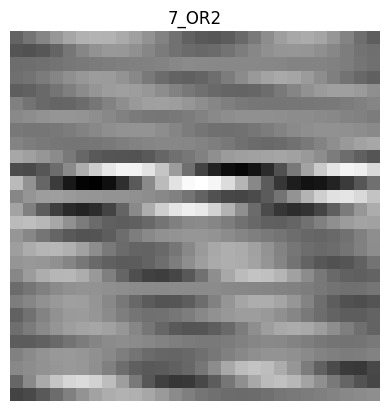

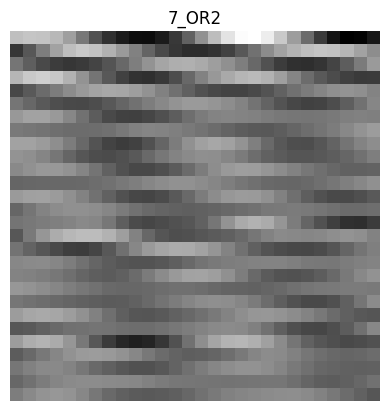

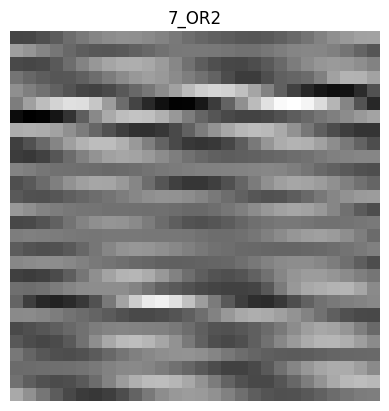

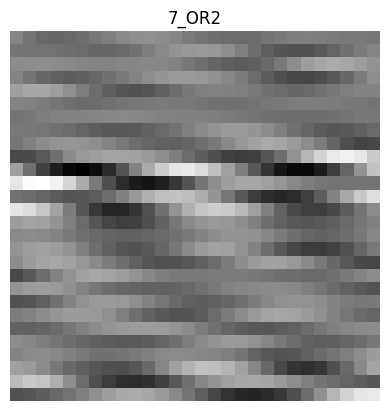

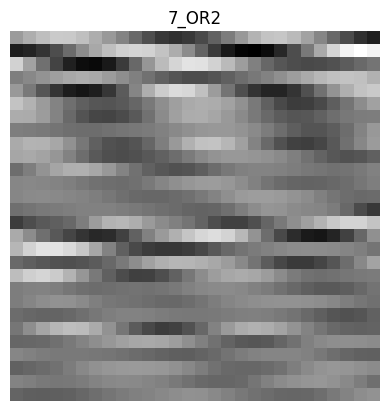

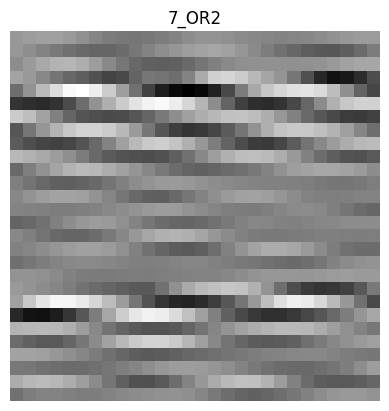

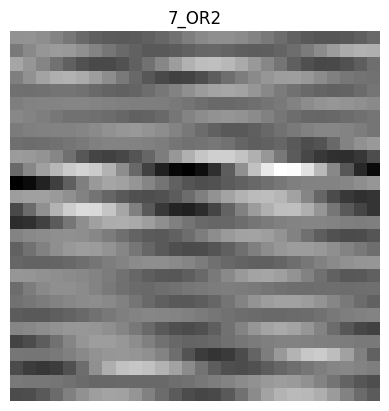

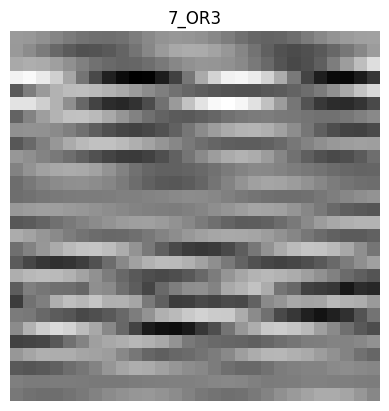

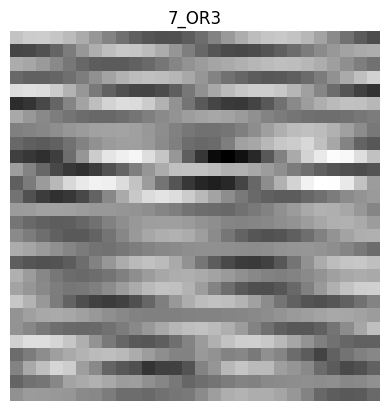

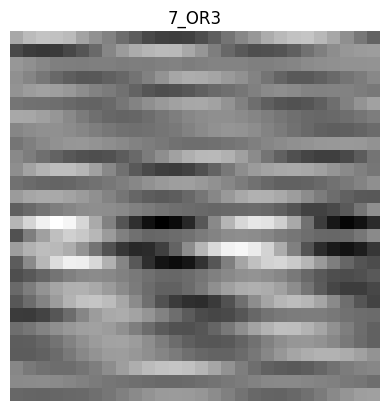

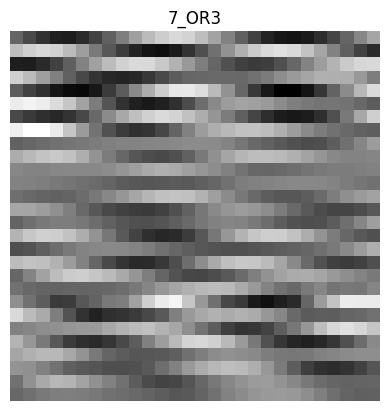

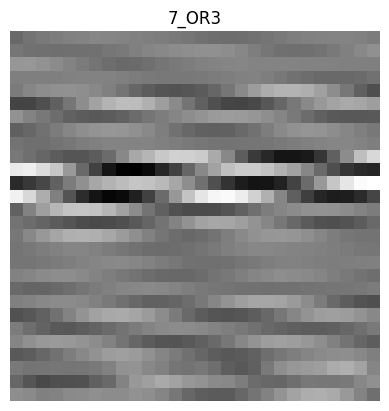

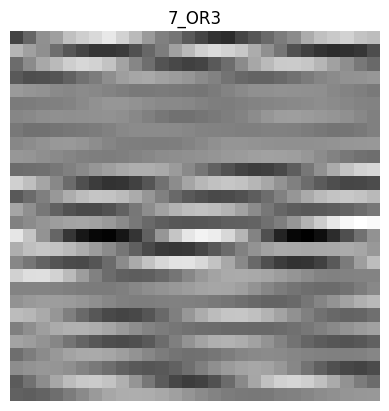

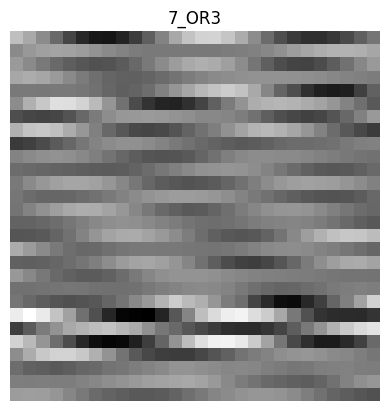

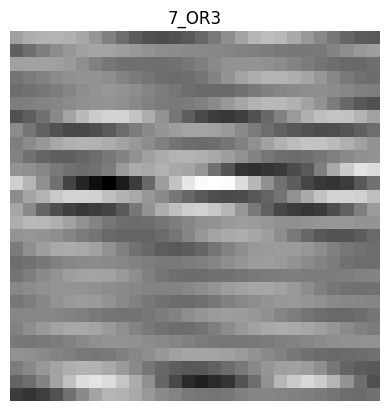

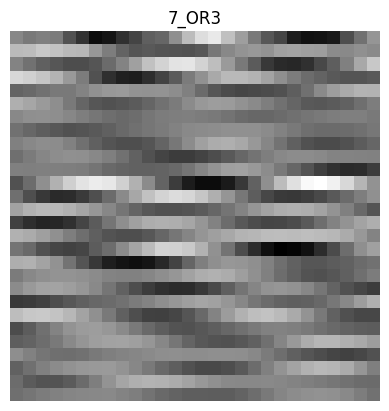

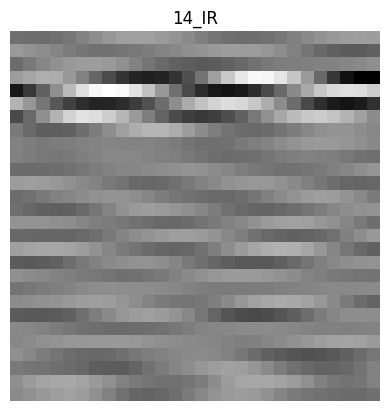

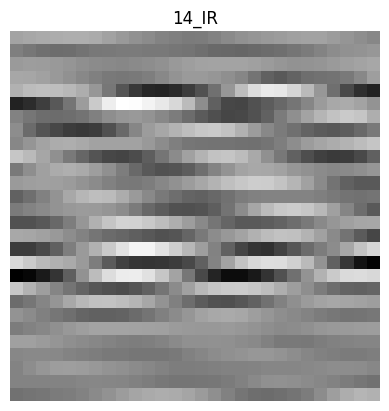

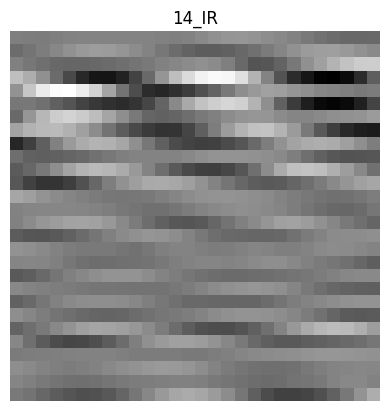

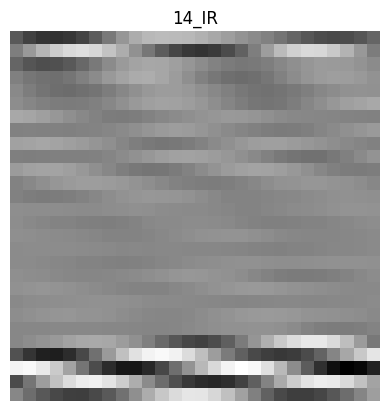

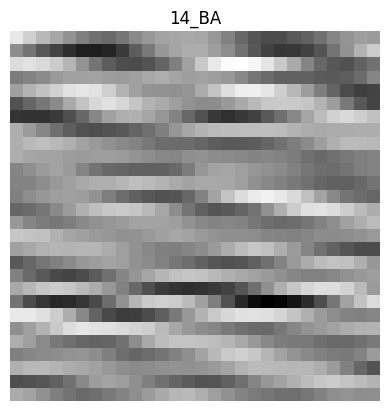

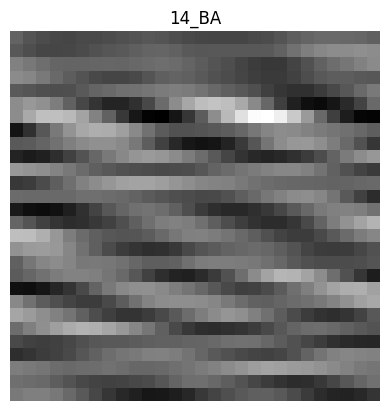

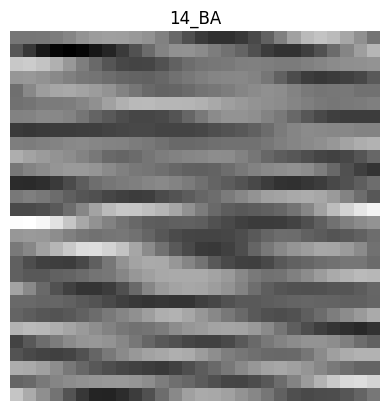

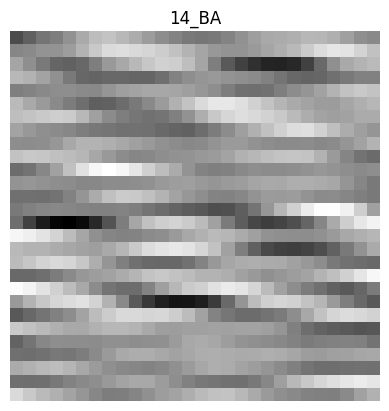

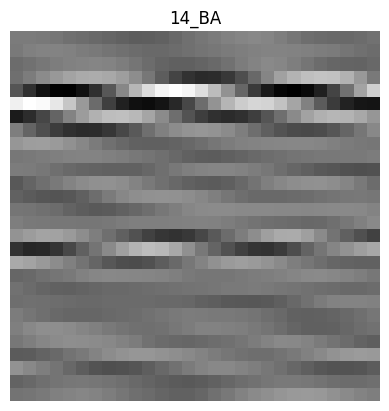

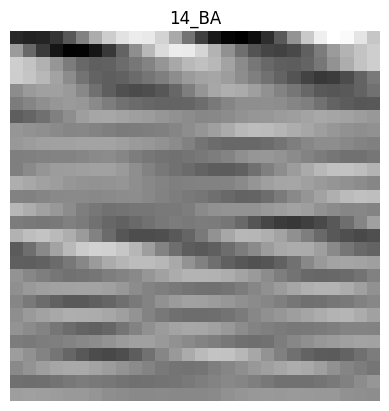

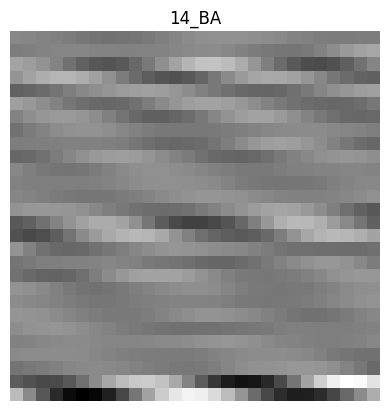

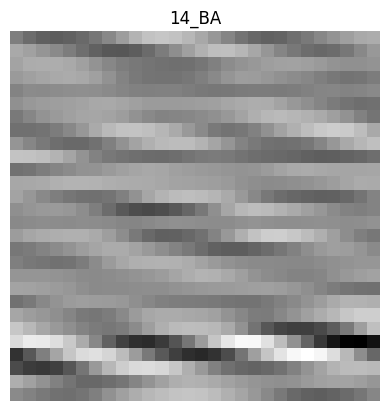

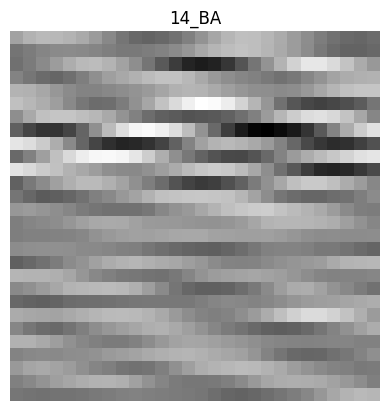

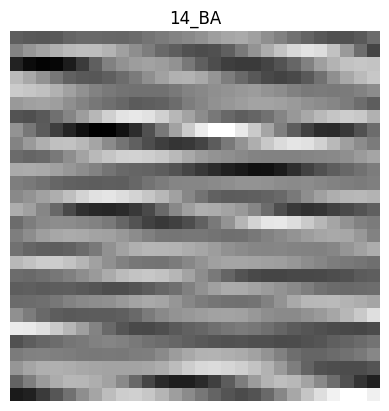

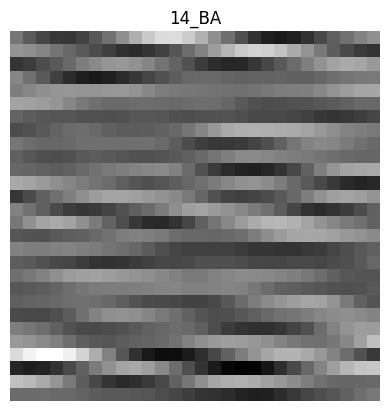

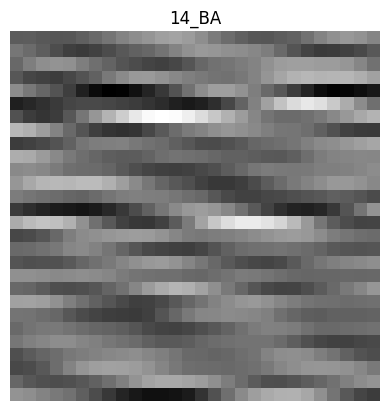

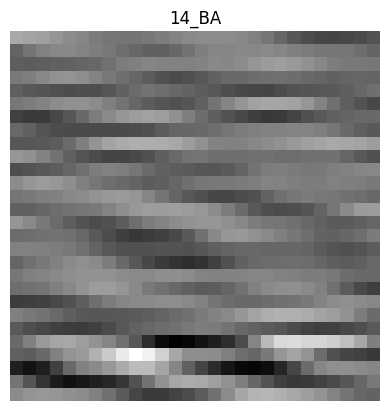

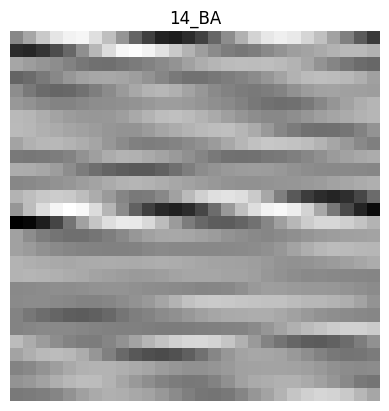

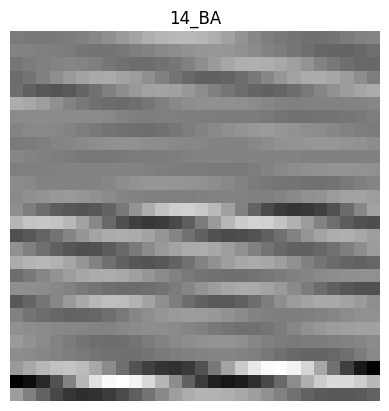

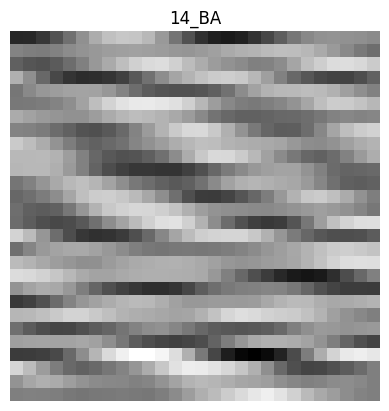

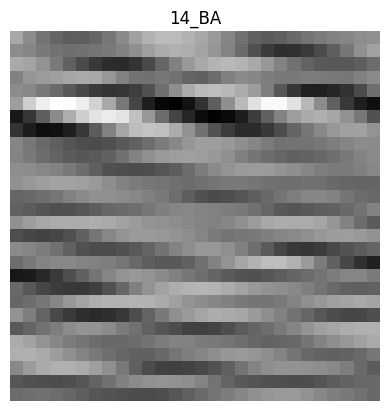

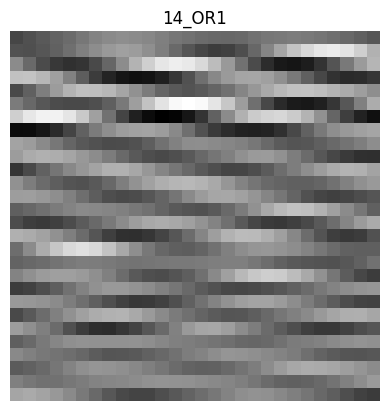

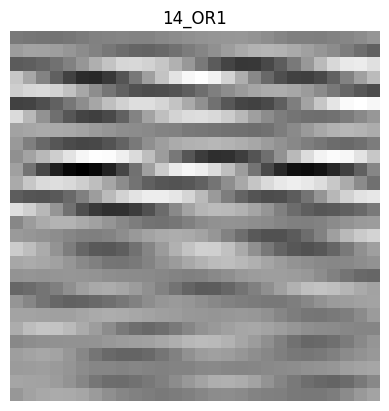

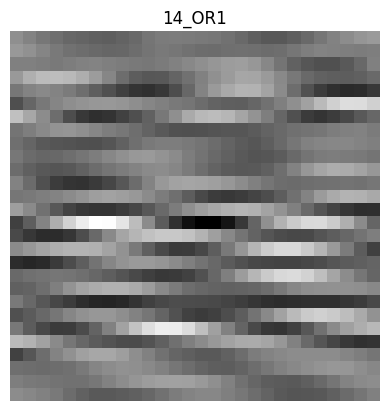

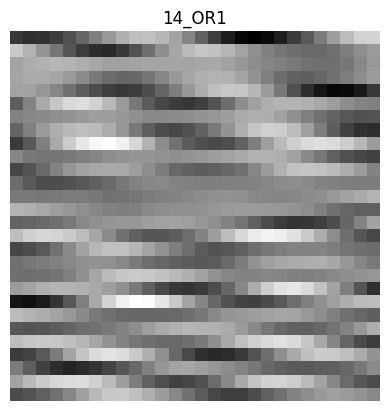

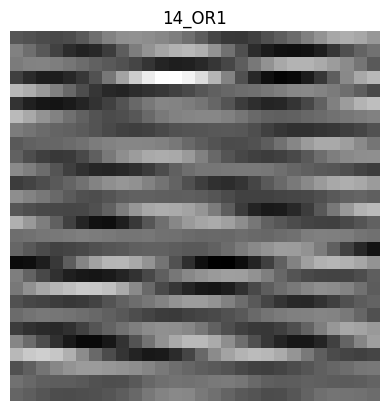

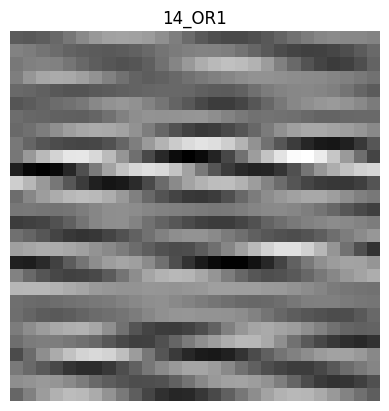

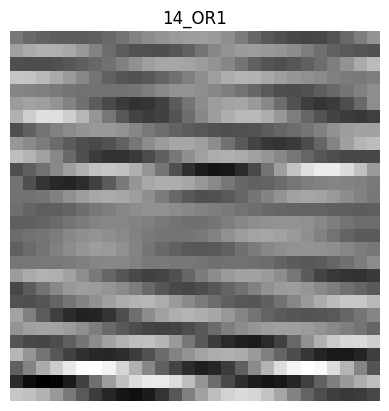

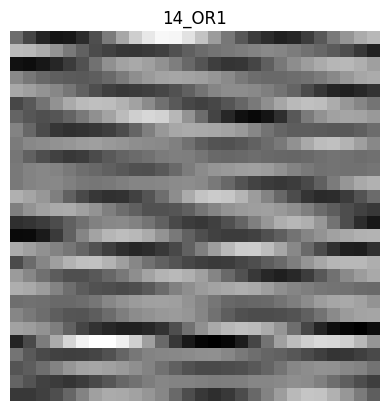

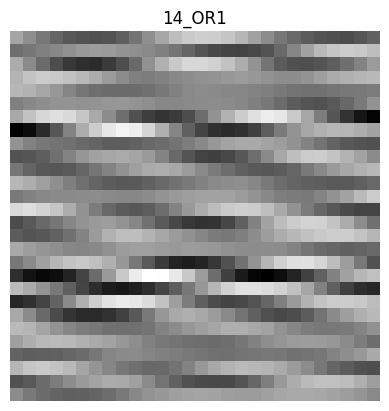

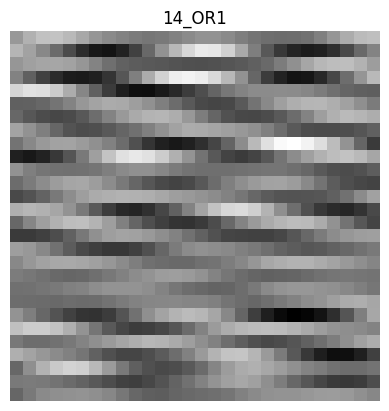

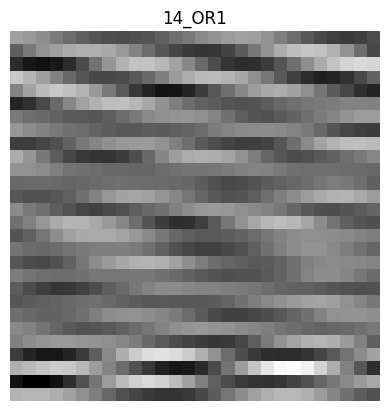

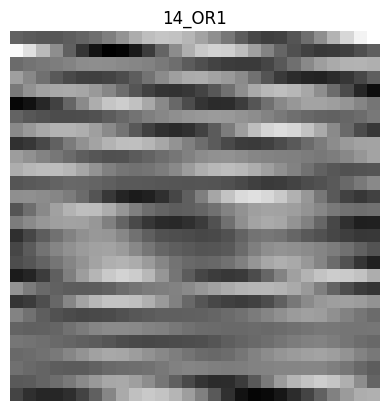

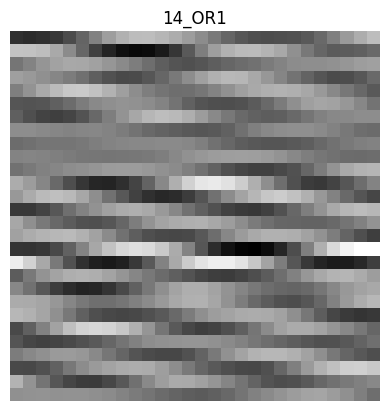

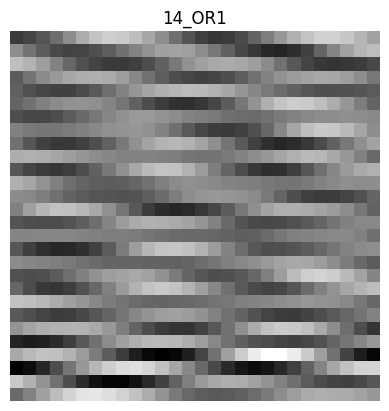

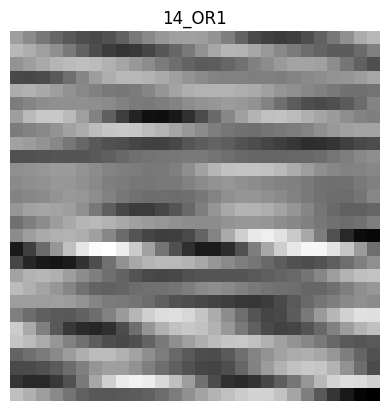

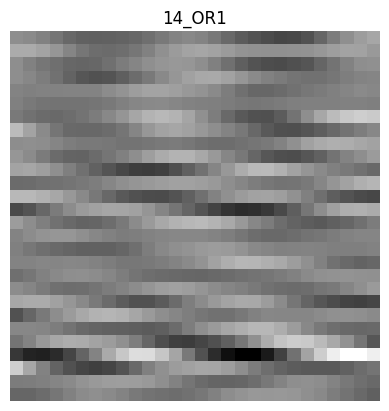

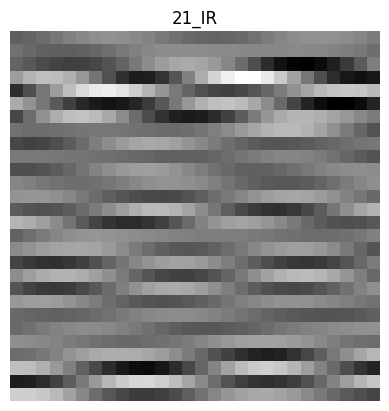

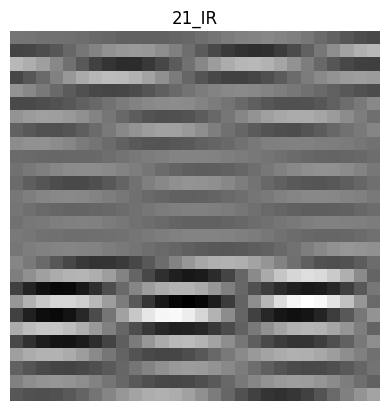

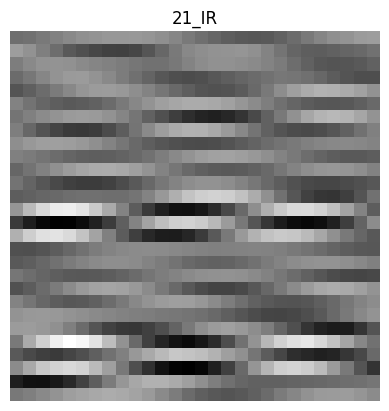

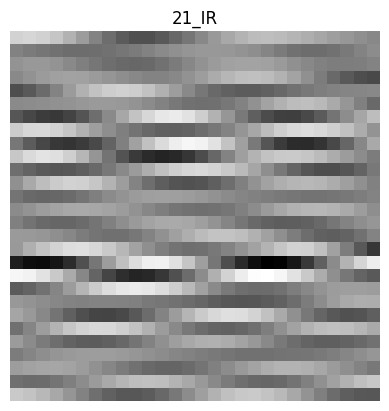

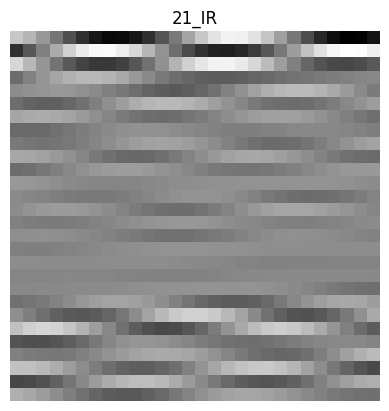

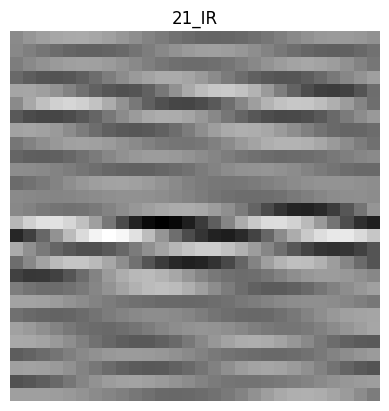

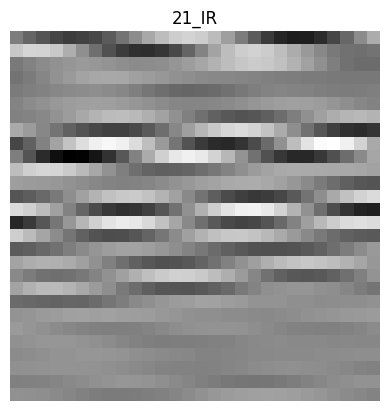

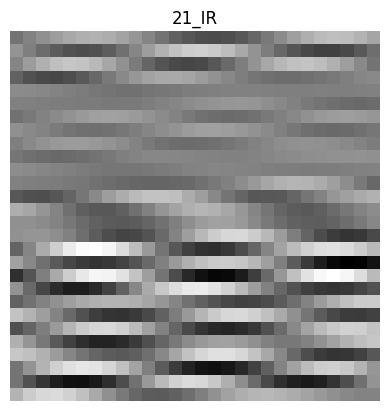

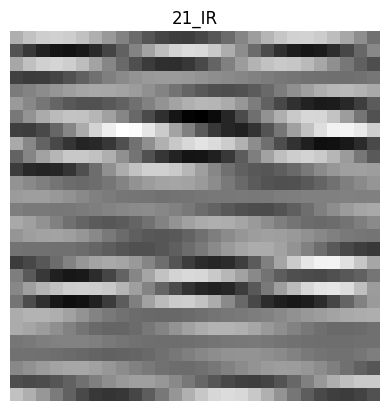

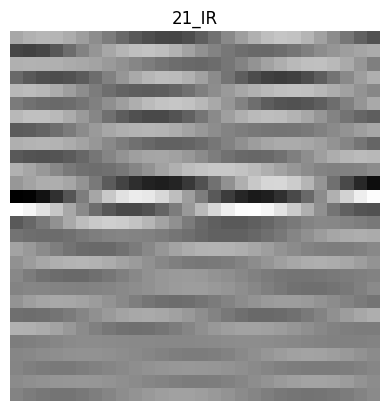

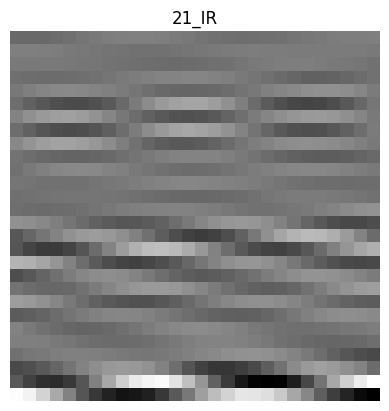

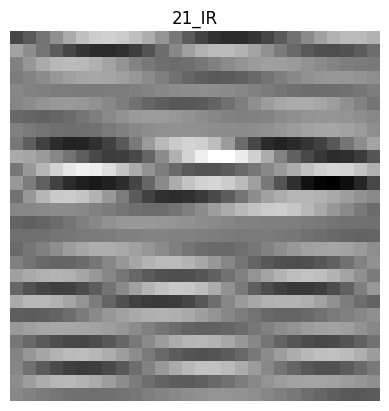

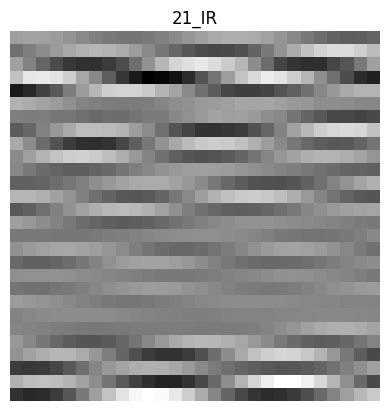

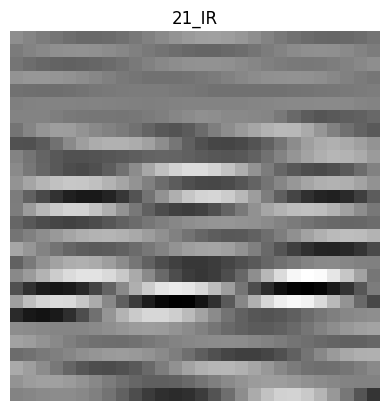

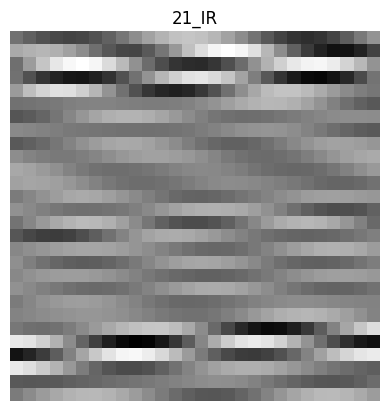

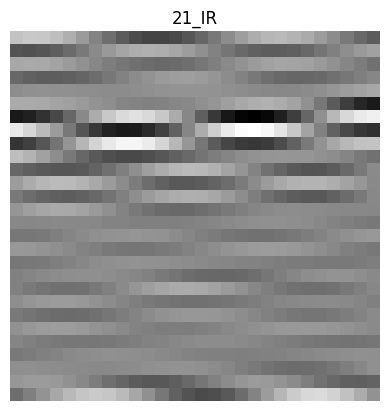

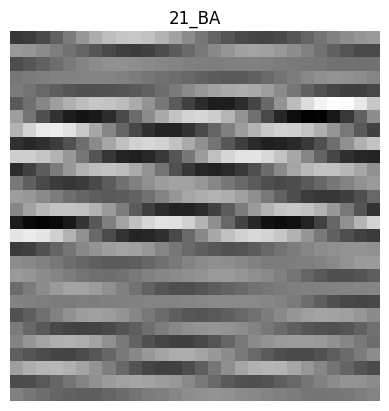

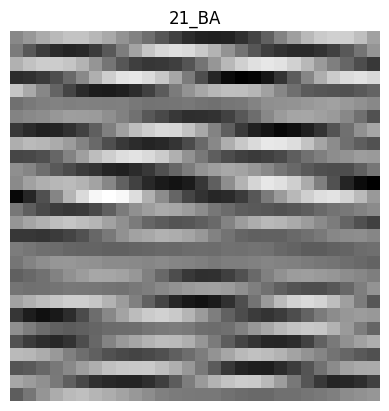

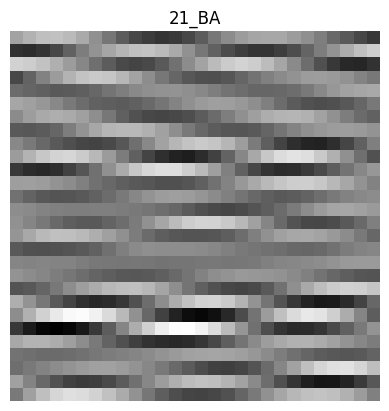

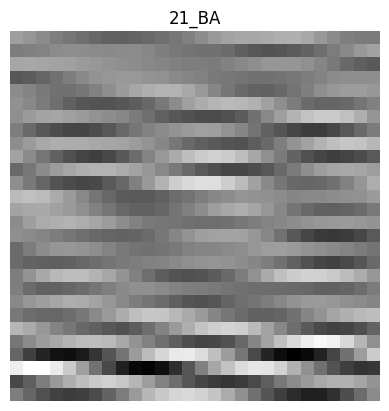

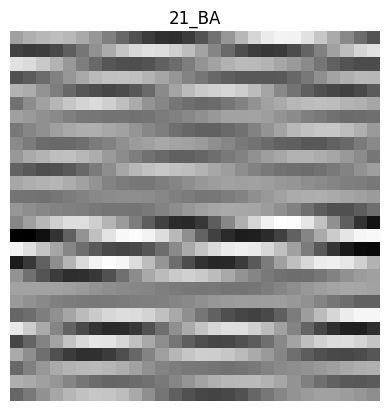

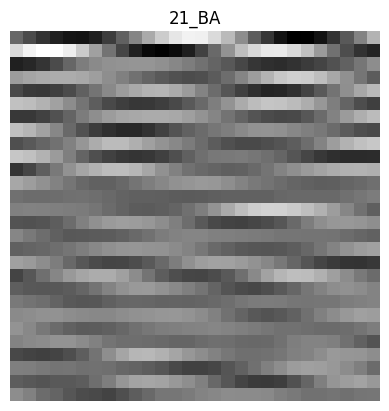

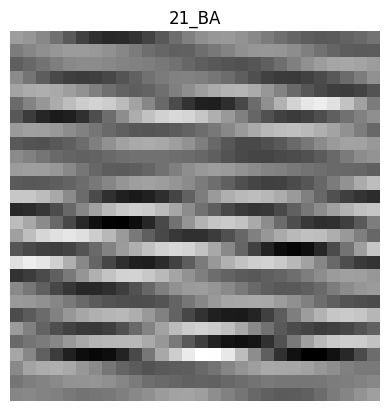

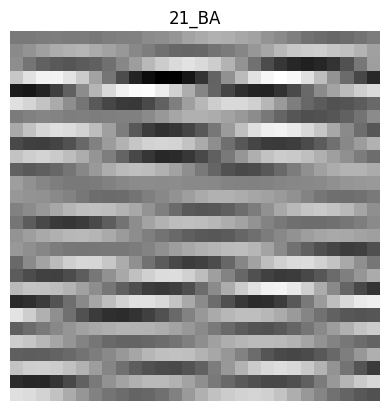

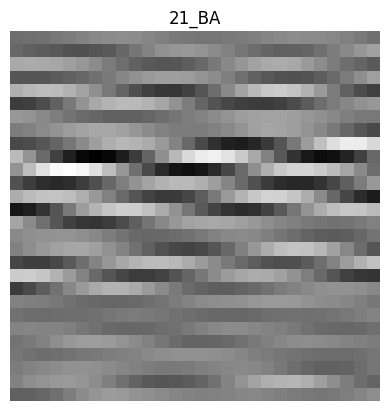

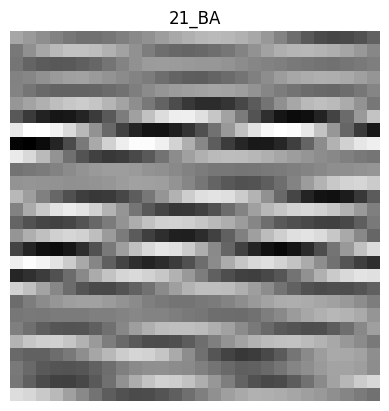

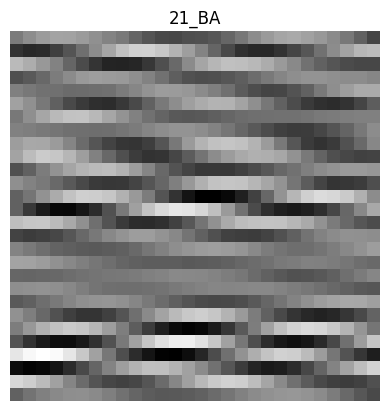

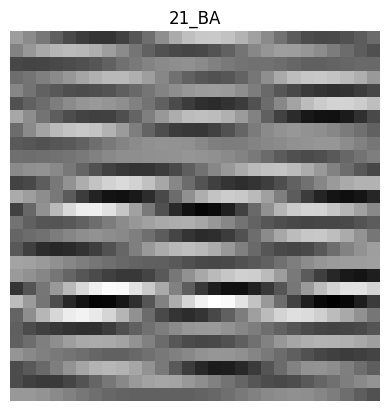

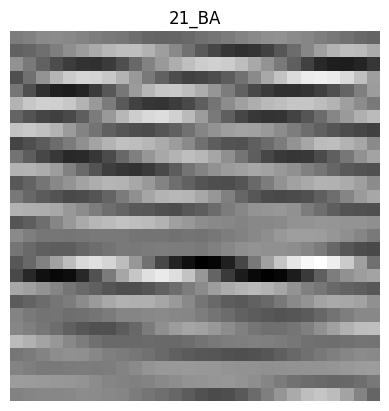

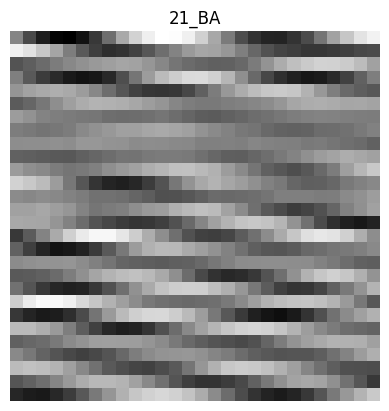

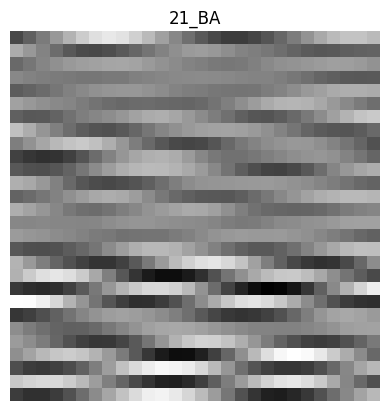

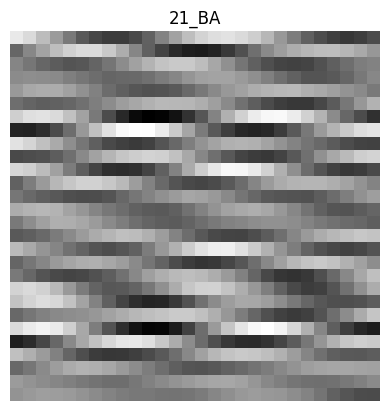

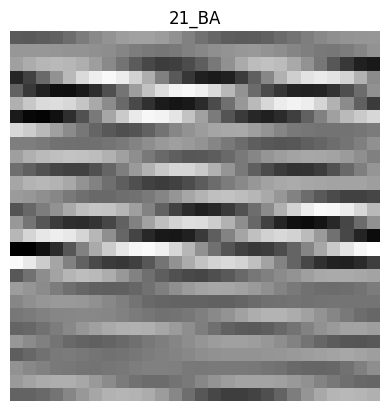

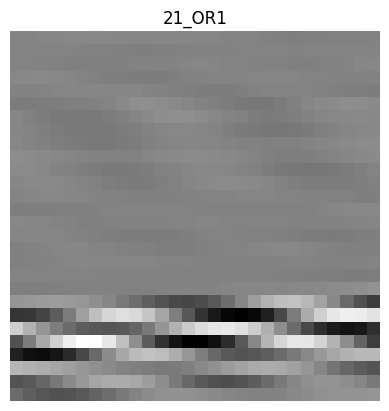

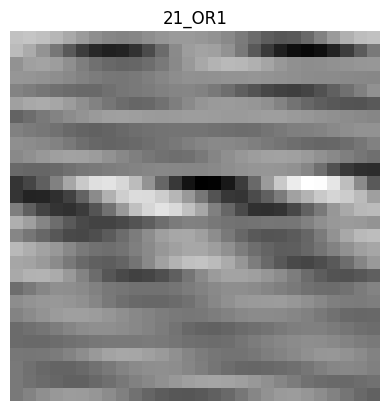

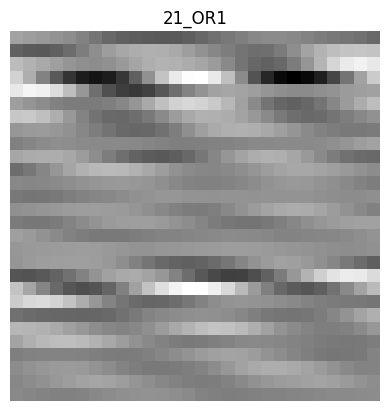

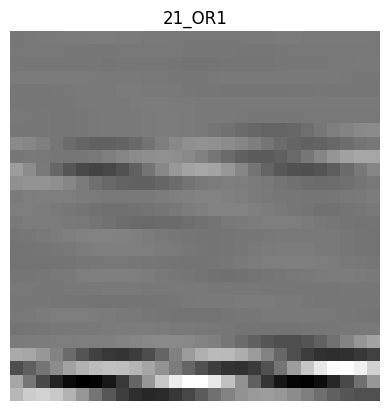

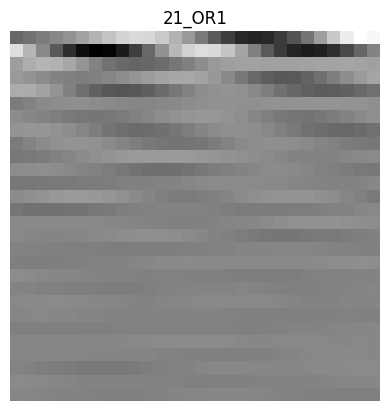

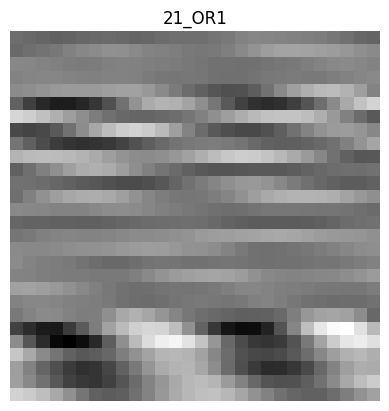

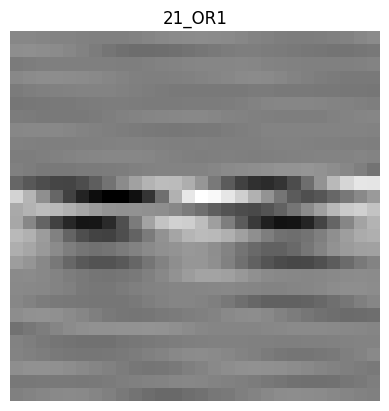

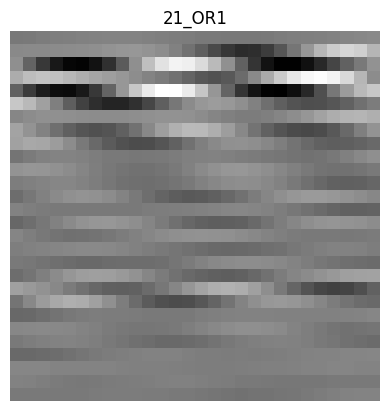

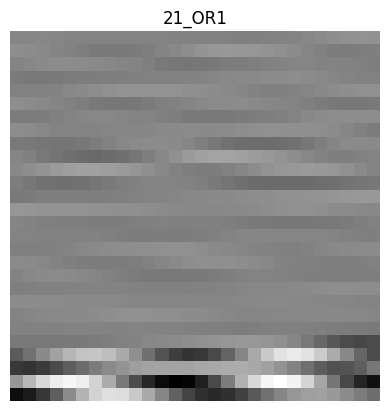

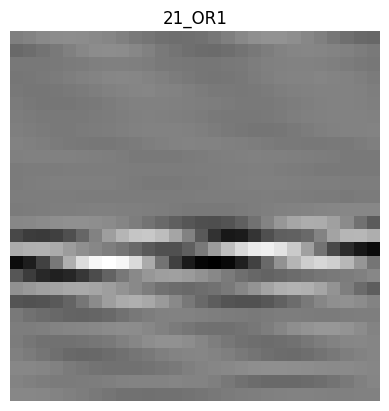

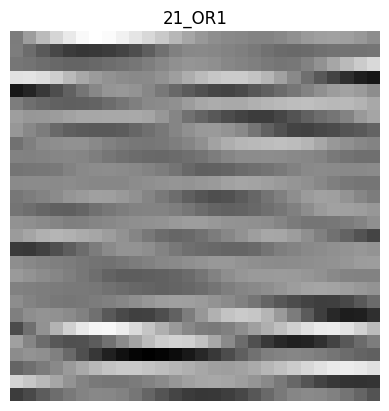

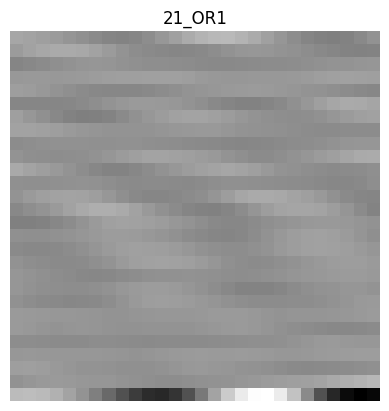

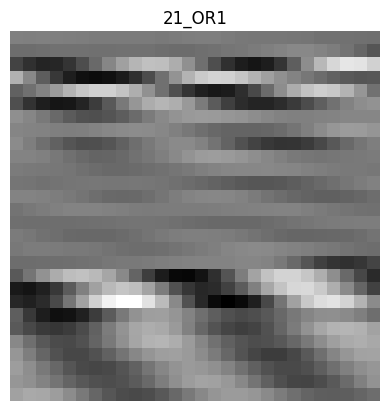

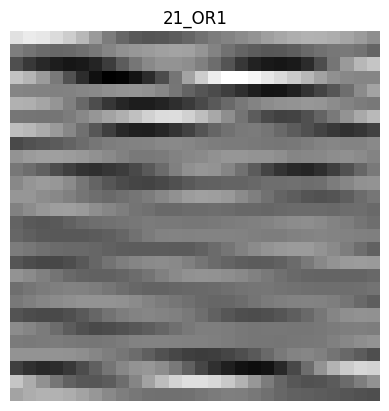

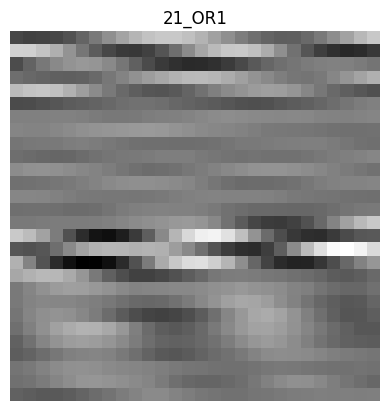

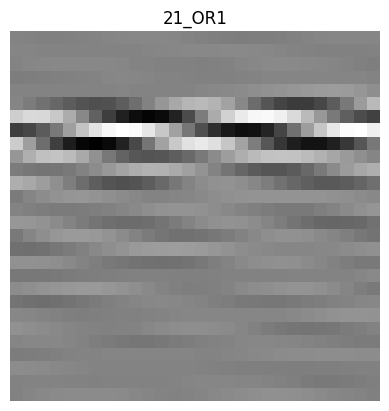

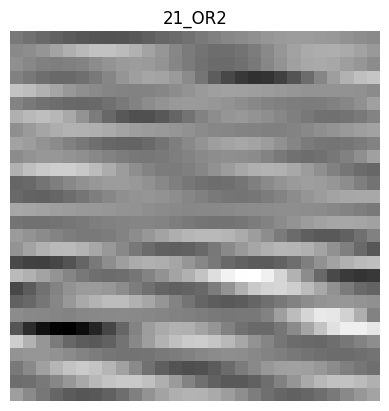

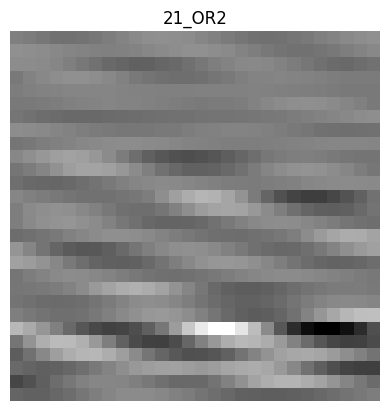

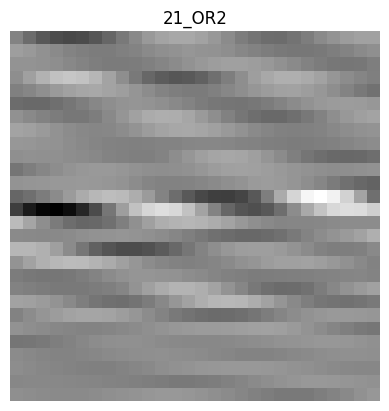

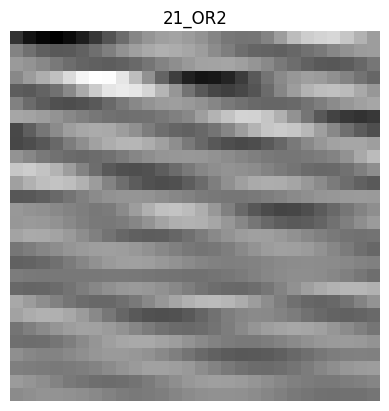

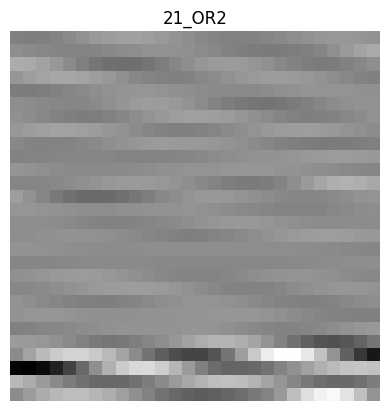

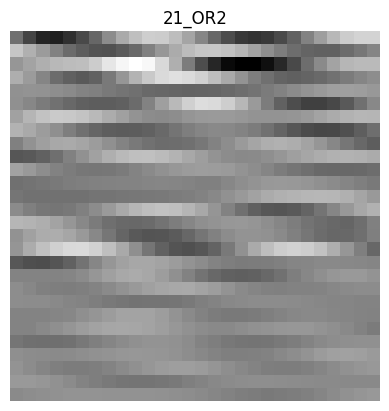

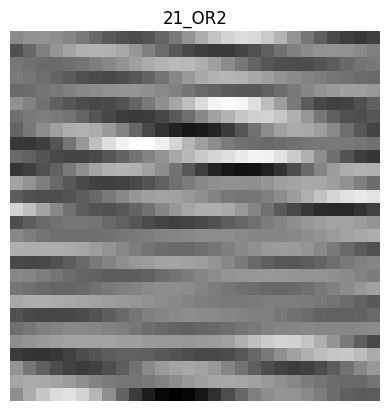

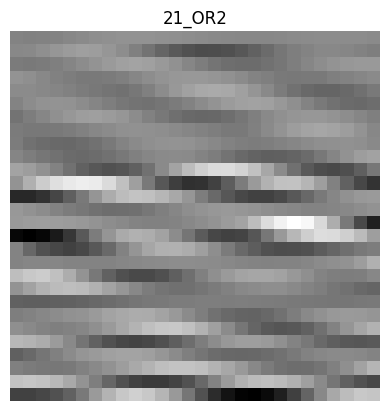

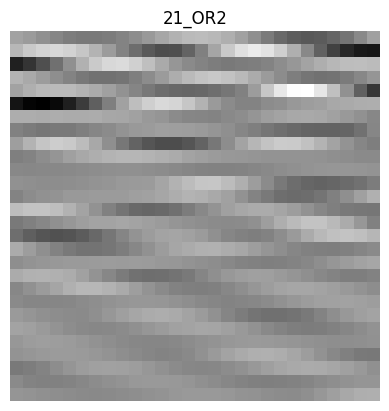

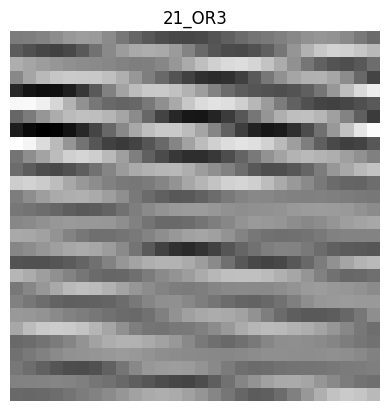

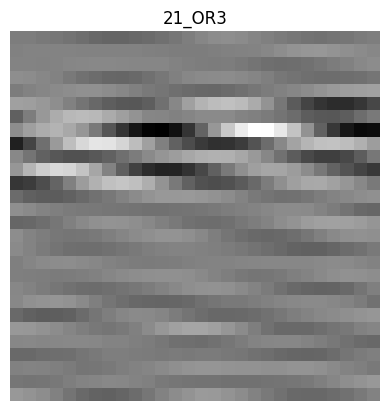

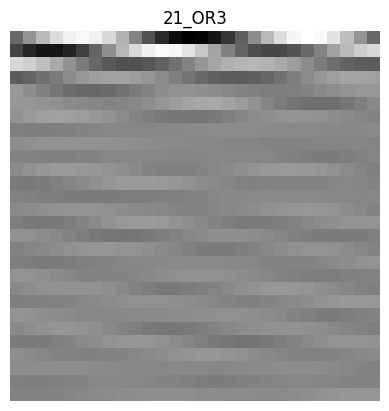

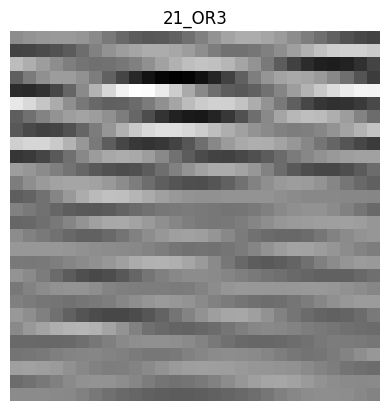

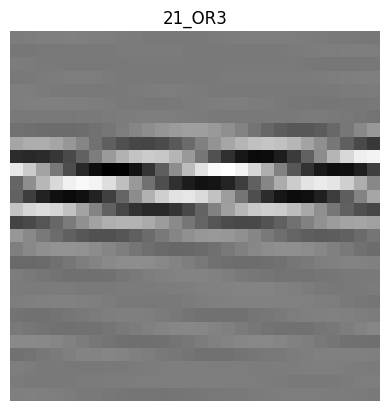

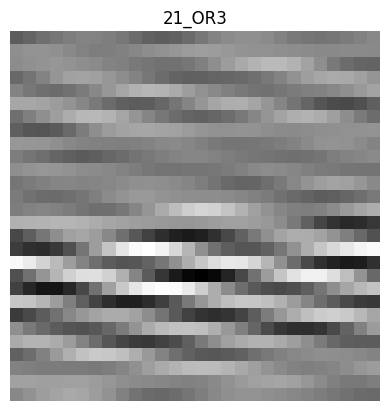

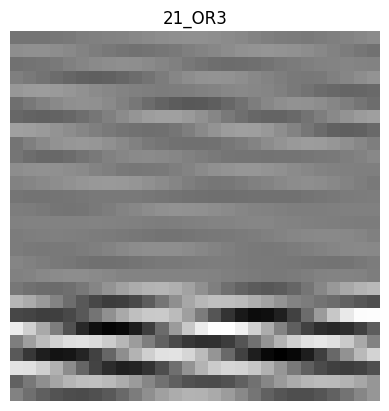

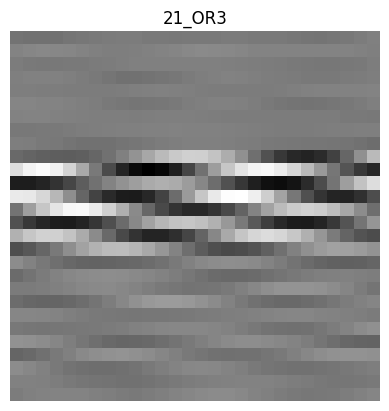

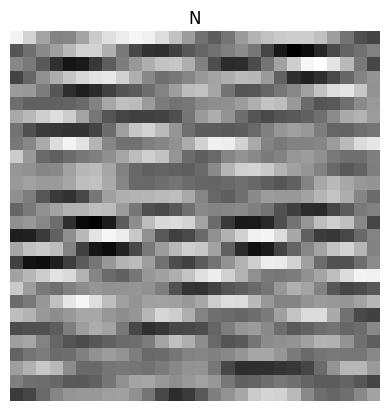

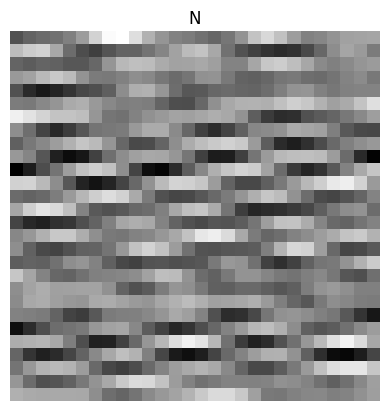

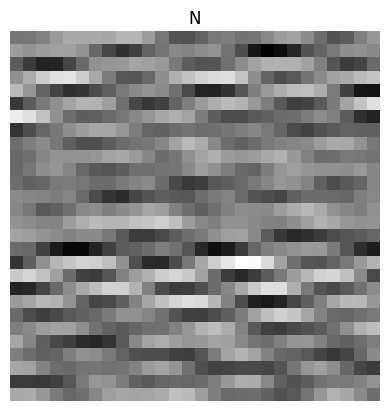

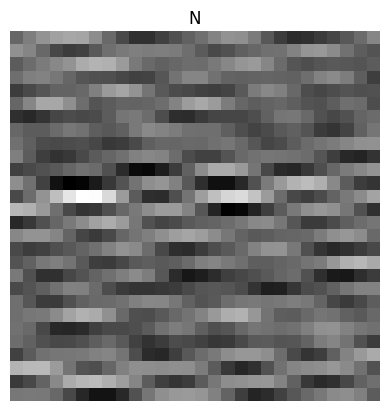

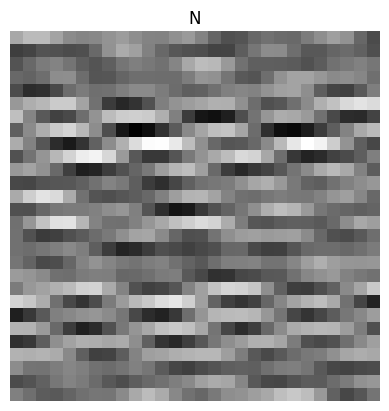

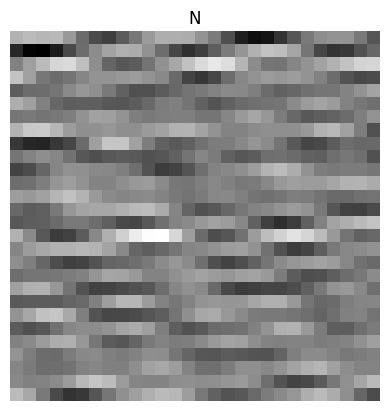

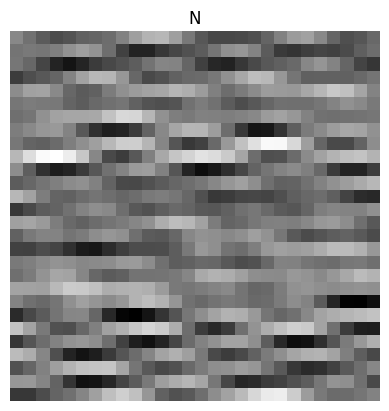

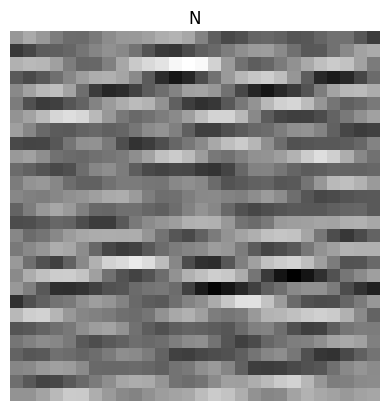

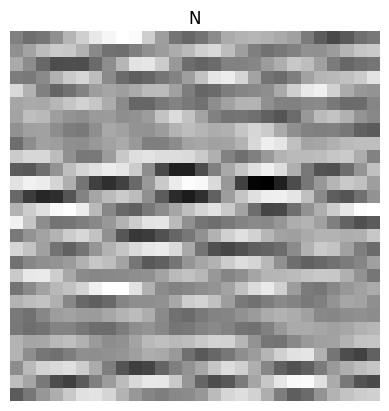

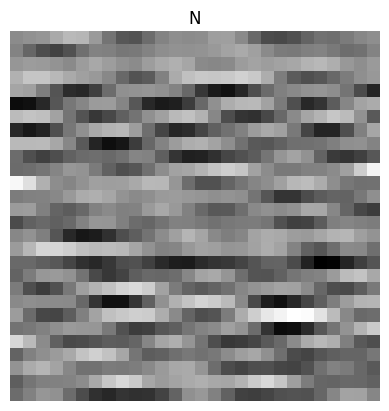

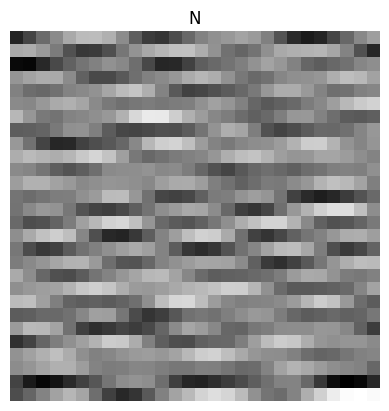

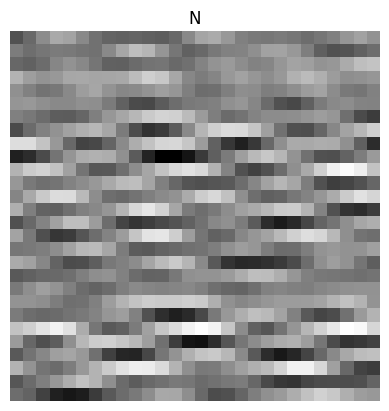

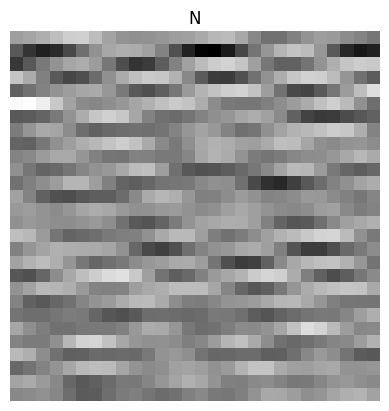

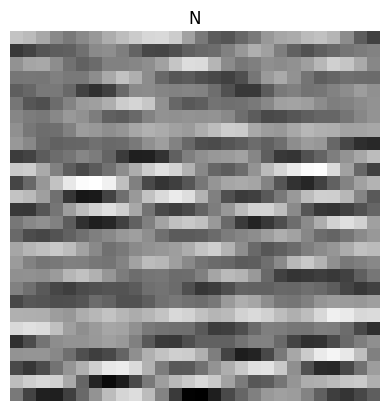

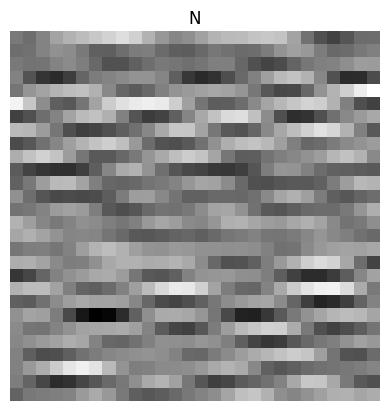

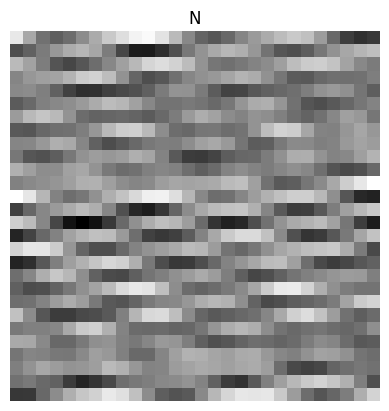

In [8]:
from matplotlib.pyplot import imread


for idx in range(0,9244,50):
    img=X[idx]

    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title(Y[idx])
    plt.show()

In [9]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,OHE_Y,test_size=0.3,shuffle=True)


In [10]:
# X_pre_cnn = X.reshape(X.shape[0],X.shape[1]*X.shape[2])

# from sklearn.manifold import TSNE

# X_t_sne = TSNE(n_components=2, learning_rate='auto',verbose=1, perplexity=40, n_iter=300).fit_transform(X_pre_cnn)

# tSNEdf = pd.DataFrame(data = X_t_sne, columns = ['t-SNE component 1', 't-SNE component 2'])

# tSNEdf['Fault']=Y


# # Plot the PC-1 and PC-2
# fig, ax = plt.subplots(figsize=(7,7))
# sns.scatterplot(x=tSNEdf['t-SNE component 1'],y=tSNEdf['t-SNE component 2'],hue='Fault',
#     data=tSNEdf,
#     legend="full",
#     alpha=0.3)
# plt.show()

In [84]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D

no_classes = len(df['fault'].unique())
# Define the input shape based on your X_train data
# Replace (X_train.shape[1], X_train.shape[2], 1) with your actual input shape
inputs = Input(shape=(X_train.shape[1], X_train.shape[2], 1))

# Define the CNN layers
x = Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
x = MaxPooling2D((2, 2), strides=(2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), padding='same')(x)
x = Flatten()(x)
features = Dense(128, activation='relu')(x)  # This layer’s output will be used for t-SNE
outputs = Dense(no_classes, activation='softmax')(features)  # Replace no_classes with your number of classes

# Create the main CNN model
cnn_model = Model(inputs=inputs, outputs=outputs)



# Compile and train the main model (if not already trained)
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])




In [85]:
cnn_model.summary()

Model: "functional_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)          │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_37 (Conv2D)                   │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_37 (MaxPooling2D)      │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_38 (Conv2D)                   │ (None, 14, 14, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_38 (MaxPooling2D)      │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_15 (Flatten)                 │ (None, 3136)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 128)                 │         401,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 14)                  │           1,806 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 422,158 (1.61 MB)

 Trainable params: 422,158 (1.61 MB)

 Non-trainable params: 0 (0.00 B)

In [86]:
batch_size = 400
epochs = 20
history = cnn_model.fit(X_train, y_train, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(X_test,y_test),shuffle=True)


Epoch 1/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 476ms/step - accuracy: 0.1748 - loss: 2.3594 - val_accuracy: 0.4986 - val_loss: 1.6293
Epoch 2/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 445ms/step - accuracy: 0.5339 - loss: 1.5132 - val_accuracy: 0.7578 - val_loss: 0.9955
Epoch 3/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 451ms/step - accuracy: 0.7962 - loss: 0.8549 - val_accuracy: 0.8576 - val_loss: 0.4754
Epoch 4/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 458ms/step - accuracy: 0.8717 - loss: 0.4338 - val_accuracy: 0.8634 - val_loss: 0.3760
Epoch 5/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 432ms/step - accuracy: 0.8981 - loss: 0.3037 - val_accuracy: 0.9293 - val_loss: 0.2278
Epoch 6/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 463ms/step - accuracy: 0.9304 - loss: 0.2241 - val_accuracy: 0.9322 - val_loss: 0.1933
Epoch 7/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 430ms/step - accuracy: 0.9438 - loss: 0.1848 - val_accuracy: 0.9466 - val_loss: 0.1670
Epoch 8/20
17/17 ━━━━━━━━━━━━━━━━━━━━ 7s 419ms/step - accuracy: 0.9562 - loss: 0.1534 - val_accuracy: 0.

In [87]:
# Create the dummy model to extract features from the second-to-last layer
dummy_cnn = Model(inputs=cnn_model.input,outputs=cnn_model.layers[-2].output)
# Extract features for t-SNE
y_viz = dummy_cnn.predict(X_train)

203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step


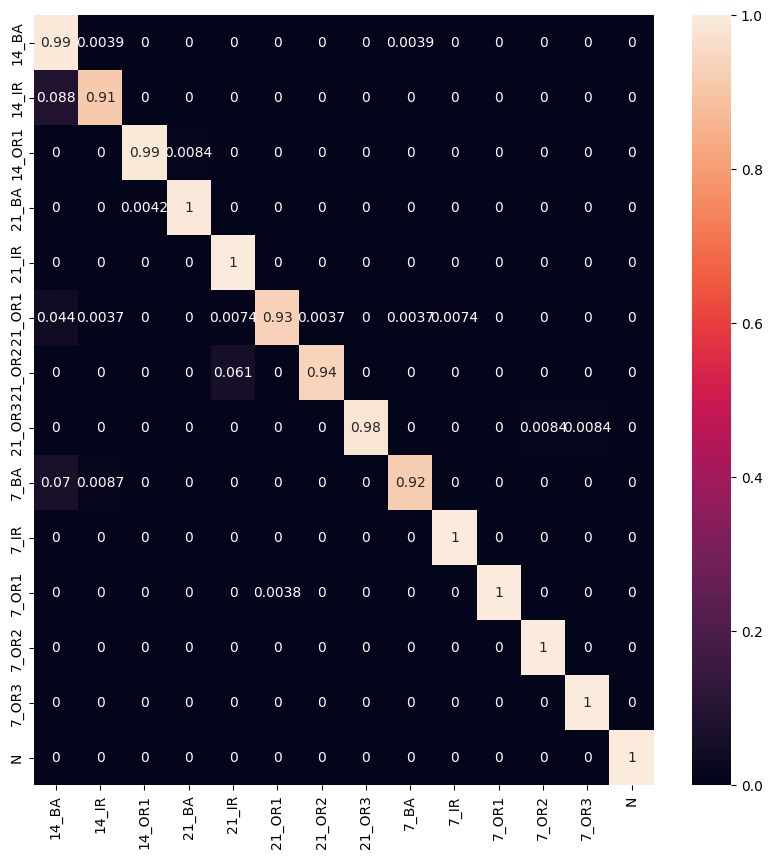

In [88]:
def inv_Transform_result(y_pred):
    y_pred = y_pred.argmax(axis=1)
    y_pred = encoder.inverse_transform(y_pred)
    return y_pred



y_pred=cnn_model.predict(X_test)


Y_pred=inv_Transform_result(y_pred)
Y_test = inv_Transform_result(y_test)




from sklearn.metrics import confusion_matrix


plt.figure(figsize=(10,10))
cm = confusion_matrix(Y_test, Y_pred,normalize='true')
f = sns.heatmap(cm, annot=True,xticklabels=encoder.classes_,yticklabels=encoder.classes_)
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 6472 samples in 0.001s...
[t-SNE] Computed neighbors for 6472 samples in 0.198s...
[t-SNE] Computed conditional probabilities for sample 1000 / 6472
[t-SNE] Computed conditional probabilities for sample 2000 / 6472
[t-SNE] Computed conditional probabilities for sample 3000 / 6472
[t-SNE] Computed conditional probabilities for sample 4000 / 6472
[t-SNE] Computed conditional probabilities for sample 5000 / 6472
[t-SNE] Computed conditional probabilities for sample 6000 / 6472
[t-SNE] Computed conditional probabilities for sample 6472 / 6472
[t-SNE] Mean sigma: 1.698079
[t-SNE] KL divergence after 250 iterations with early exaggeration: 63.967323
[t-SNE] KL divergence after 300 iterations: 1.919676


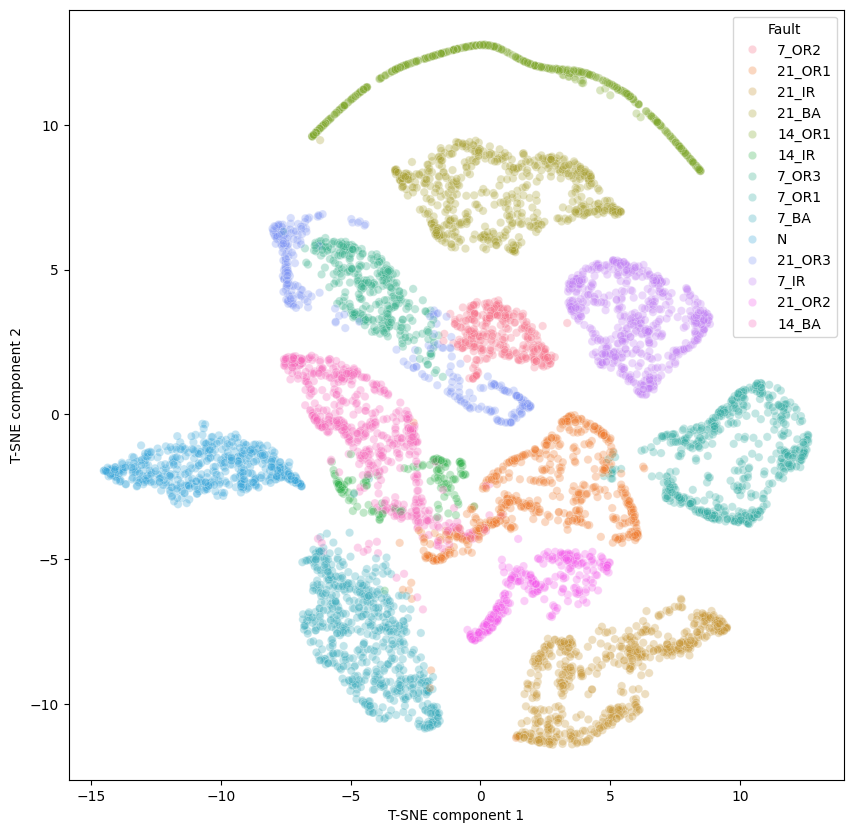

In [89]:
from sklearn.manifold import TSNE

X_t_sne = TSNE(n_components=2, learning_rate='auto',verbose=1, perplexity=40, n_iter=300).fit_transform(y_viz)

tSNEdf = pd.DataFrame(data = X_t_sne, columns = ['T-SNE component 1', 'T-SNE component 2'])

tSNEdf['Fault']=inv_Transform_result(y_train)


# Plot the PC-1 and PC-2
fig, ax = plt.subplots(figsize=(10,10))
sns.scatterplot(x=tSNEdf['T-SNE component 1'],y=tSNEdf['T-SNE component 2'],hue='Fault',
    data=tSNEdf,
    legend="full",
    alpha=0.3)
plt.show()

In [90]:
cnn_model.save('/content/drive/MyDrive/48kz/cnn_model.h5')

In [93]:
tSNEdf.to_csv('/content/drive/MyDrive/48kz/tsne_data.csv', index=False)

In [3]:
pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 67.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 81.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 6.1 MB/s eta 0:00:00


In [95]:
import streamlit as st

In [4]:
!wget -q -O - ipv4.icanhazip.com

34.125.66.226


In [5]:
!npm install localtunnel

⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙
added 22 packages in 4s
⠙
⠙3 packages are looking for funding
⠙  run `npm fund` for details
⠙

In [109]:
!wget -q -O - ipv4.icanhazip.com

34.58.175.106


In [ ]:
!streamlit run /content/app.py &>/dev/null&
!npx localtunnel --port 8501

⠙your url is: https://funny-clocks-sniff.loca.lt


In [ ]:
import streamlit as st
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.preprocessing import LabelEncoder

# Load trained model
model = load_model("/content/drive/MyDrive/48kz/cnn_model.h5")

# Label Encoder for fault classification (ensure same encoding as training)
fault_classes = ['7_IR', '14_IR', '21_IR', '7_OR', '14_OR', '21_OR', '7_BA', '14_BA', '21_BA']
encoder = LabelEncoder()
encoder.fit(fault_classes)

def preprocess_input_data(data):
    """Convert input vibration readings to 28x28 format for CNN."""
    data = np.array(data).reshape((28, 28, 1))  # Reshape for CNN input
    return np.expand_dims(data, axis=0)  # Add batch dimension

def predict_fault(vibration_data):
    """Predict fault type based on input vibration readings."""
    processed_data = preprocess_input_data(vibration_data)
    prediction = model.predict(processed_data)
    fault_label = encoder.inverse_transform([np.argmax(prediction)])[0]
    return fault_label

# Streamlit UI
st.title("CWRU Bearing Fault Detection")
st.write("Provide vibration readings to predict fault type.")

# Input Method
input_method = st.radio("Select Input Method", ("Manual Entry", "Upload CSV"))

if input_method == "Manual Entry":
    input_values = st.text_area("Enter 784 values (comma-separated)")
    if st.button("Predict"):
        try:
            values = list(map(float, input_values.split(",")))
            if len(values) == 784:
                fault = predict_fault(values)
                st.success(f"Predicted Fault: {fault}")
            else:
                st.error("Please enter exactly 784 values.")
        except:
            st.error("Invalid input. Ensure only numeric values are entered.")

elif input_method == "Upload CSV":
    uploaded_file = st.file_uploader("Upload CSV file", type=["csv"])
    if uploaded_file is not None:
        df = pd.read_csv(uploaded_file, header=None)
        if df.shape == (28, 28):
            fault = predict_fault(df.values.flatten())
            st.success(f"Predicted Fault: {fault}")
        else:
            st.error("CSV should contain 784 values in a 28x28 format.")
